In [1]:
import numpy as np
import umap
import phenograph
from scipy import stats
import seaborn as sns
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
from sklearn import cluster, preprocessing, decomposition

from meshparty import meshwork, trimesh_vtk
from caveclient import CAVEclient

from common_setup import project_info, project_paths
import plotting_code
import feature_clustering as fc
import tqdm

def relabel_sorted(df, label_column, sort_column, ascending=True):
    sorted_label = (
        df.groupby(label_column)
        .agg({sort_column: "mean"})
        .sort_values(by=sort_column, ascending=ascending)
        .index.values
    )
    relabel_index = {x: ii for ii, x in enumerate(sorted_label)}
    df[label_column] = df[label_column].apply(lambda x: relabel_index[x])

    
    

sk_dir = f"{project_paths.skeletons}/skeleton_files"
base_path = f"{project_paths.base}/pipelines"
height_bounds = np.load(f"{project_paths.data}/height_bounds_v1.npy")
width_bounds = np.load(f"{project_paths.data}/width_bounds_v1.npy")
layer_bounds = np.load(f"{project_paths.data}/layer_bounds_v3.npy")

feature_dir = f"{project_paths.data}/features/features_feb7"

version = 795
data_dir = f'paper_versions/v{version}/data'
plot_dir = f'paper_versions/v{version}/plots'
plot_data_dir = f"{plot_dir}/associated_data"

syn_df = pd.read_feather(f"{data_dir}/syn_i_df.feather")

In [2]:
layer_bounds

array([ 91.80615154, 261.21908419, 391.8631847 , 537.04973966,
       753.58049474])

In [2]:
dfct_e = pd.read_feather(f"{data_dir}/dfct_e.feather")
e_cell_count = dfct_e.groupby('hlabel').count()[['root_id']].rename(columns={'root_id': 'num_cell'})

height_bounds = height_bounds - height_bounds[0]

In [3]:
import feature_clustering as fc
import tqdm
from affine_transform import minnie_column_transform_nm, minnie_column_transform
tform_nm = minnie_column_transform_nm()
tform = minnie_column_transform()
from numbers import Number
from matplotlib import colors

clr = [0.3, 0.9, 0.8]


def path_line(path, sk, x_ind=0, y_ind=1, rescale=1):
    xs = sk.vertices[path, x_ind].squeeze()
    ys = sk.vertices[path, y_ind].squeeze()
    return xs / rescale, ys / rescale


def all_paths(sk, x_ind=0, y_ind=1, rescale=1):
    all_xs = []
    all_ys = []
    for path in sk.cover_paths_with_parent():
        xs, ys = path_line(path, sk, x_ind=x_ind, y_ind=y_ind, rescale=rescale)
        all_xs.append(np.atleast_1d(xs))
        all_xs.append(np.array([np.nan]))
        all_ys.append(np.atleast_1d(ys))
        all_ys.append(np.array([np.nan]))
    return np.concatenate(all_xs), np.concatenate(all_ys)


def darken_color(clr, delta=0.3):
    clr_hsv = colors.rgb_to_hsv(clr)
    vdiff = clr_hsv[2]
    return colors.hsv_to_rgb([x - delta * y for x, y in zip(clr_hsv, [0, 0, vdiff])])


def lighten_color(clr, delta=0.3):
    clr_hsv = colors.rgb_to_hsv(clr)
    vdiff = 1 - clr_hsv[2]
    return colors.hsv_to_rgb([x + delta * y for x, y in zip(clr_hsv, [0, 0, vdiff])])

def sample_width(
    root_id,
    x_offset=0,
    rescale=1000,
    dendrite_only=True,
    axon_anno=None,
    dendrite_anno=None,
    min_x=None,
    transform=None,
):
    if isinstance(root_id, Number):
        nrn = fc.io_utils.load_root_id(root_id, project_paths)
    else:
        nrn = root_id
    
    if transform:
        nrn.skeleton.vertices = transform.apply(nrn.skeleton.vertices)

    soma_pt = np.atleast_2d(nrn.skeleton.vertices[nrn.skeleton.root]) / rescale
    soma_pt_x = soma_pt[0, 0]

    if axon_anno is not None:
        is_axon = nrn.anno[axon_anno].mesh_mask
    else:
        is_axon = ~nrn.anno[dendrite_anno].mesh_mask
        
    with nrn.mask_context(~is_axon) as nrnf:
        x_dend, y_dend = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = x_dend[~np.isnan(x_dend)]

    if not dendrite_only:
        with nrn.mask_context(is_axon) as nrnf:
            x_axon, y_axon = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = np.concatenate((x_axon[~np.isnan(x_axon)], all_x))
        
    if min_x is not None:
        if np.min(all_x - soma_pt_x) + x_offset < min_x:
            x_offset = min_x + np.abs(np.min(all_x - soma_pt_x)) - soma_pt_x
    else:
        x_offset = x_offset - soma_pt_x

    return max(all_x+x_offset)

def plot_neuron(
    root_id,
    color,
    x_offset=0,
    ax=None,
    dendrite_only=True,
    axon_color=None,
    rescale=1000,
    axon_anno=None,
    dendrite_anno=None,
    axon_kwargs={},
    dendrite_kwargs={},
    soma_kwargs={},
    min_x=None,
    return_extent=False,
    transform=None
):
    if isinstance(root_id, Number):
        nrn = fc.io_utils.load_root_id(root_id, project_paths)
    else:
        nrn = root_id
    
    if transform:
        nrn.skeleton.vertices = transform.apply(nrn.skeleton.vertices)
        
    soma_pt = np.atleast_2d(nrn.skeleton.vertices[nrn.skeleton.root]) / rescale
    soma_pt_x = soma_pt[0, 0]
    
    if axon_anno is not None:
        is_axon = nrn.anno[axon_anno].mesh_mask
    else:
        is_axon = ~nrn.anno[dendrite_anno].mesh_mask
        
    with nrn.mask_context(~is_axon) as nrnf:
        x_dend, y_dend = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = x_dend[~np.isnan(x_dend)]

    if not dendrite_only:
        with nrn.mask_context(is_axon) as nrnf:
            x_axon, y_axon = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = np.concatenate((x_axon[~np.isnan(x_axon)], all_x))
        
    if min_x is not None:
        if np.min(all_x - soma_pt_x) + x_offset < min_x:
            x_offset = min_x + np.abs(np.min(all_x - soma_pt_x)) - soma_pt_x
    else:
        x_offset = x_offset - soma_pt_x

    if ax is None:
        ax = plt.gca()

    if axon_color is None:
        axon_color = lighten_color(color)

    if not dendrite_only:
        ax.plot(x_axon + x_offset, y_axon, color=axon_color, **axon_kwargs)
    ax.plot(x_dend + x_offset, y_dend, color=color, **dendrite_kwargs)

    ax.scatter(
        soma_pt[:, 0] + x_offset,
        soma_pt[:, 1],
        color=color,
        **soma_kwargs,
    )
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()

    if return_extent:
        return min(all_x+x_offset), max(all_x+x_offset)
    
def plot_cell_lineup(
    df,
    ax,
    root_id,
    hue,
    palette,
    offset=300,
    spacing="tight",
    spacing_gap=0,
    dendrite_only=False,
    axon_anno=None,
    dendrite_anno=None,
    axon_kwargs=None,
    dendrite_kwargs=None,
    soma_kwargs=None,
    layer_bounds=None,
    height_bounds=None,
    transform=None,
    max_width=None,
):
    if axon_kwargs is None:
        axon_kwargs = {"linewidth": 0.5}
    if dendrite_kwargs is None:
        dendrite_kwargs = {"linewidth": 1}
    if soma_kwargs is None:
        soma_kwargs = {
            "s": 18,
            "edgecolors": (1, 1, 1),
            "linewidths": 0.75,
            "zorder": 20,
        }

    xmax = 0
    for ii, (_, row) in enumerate(df.iterrows()):
        
        if spacing == "tight":
            min_x = xmax + spacing_gap
            x_offset = xmax + spacing_gap
        elif spacing == "uniform":
            min_x = None
            x_offset = ii * offset
        else:
            raise ValueError('Spacing must be "tight" or "uniform"')
            
        if dendrite_only:
            dendrite_color=palette[row[hue]]
        else:
            dendrite_color=darken_color(palette[row[hue]])
        try:
            if row[hue] == "PTC":
                del_color = 0.5
            else:
                del_color = 0.3
        except:
            del_color = 0.3
            
        if transform is None:
            rescale = 1000
        else:
            rescale = 1
            
        if max_width is not None:
            new_max = sample_width(
                row[root_id],
                x_offset=x_offset,
                transform=transform,
                axon_anno=axon_anno,
                dendrite_anno=dendrite_anno,
                dendrite_only=dendrite_only,
                rescale=rescale,
            )
            if new_max > max_width:
                ax.set_aspect("equal")
                if layer_bounds is not None and len(df)>0:
                    plotting_code.plot_layers(
                        layer_bounds,
                        depth_bounds=height_bounds,
                        span=(first_min-10, max_width),
                        ax=ax,
                        linestyle="--",
                        color=(0.5, 0.5, 0.5),
                        alpha=0.5,
                        linewidth=1,
                    )
                return df.iloc[ii:]
            
        xmin, xmax = plot_neuron(
            row[root_id],
            ax=ax,
            x_offset=x_offset,
            color=dendrite_color,
            dendrite_only=dendrite_only,
            axon_anno=axon_anno,
            dendrite_anno=dendrite_anno,
            axon_color=lighten_color(palette[row[hue]], delta=del_color),
            axon_kwargs=axon_kwargs,
            dendrite_kwargs=dendrite_kwargs,
            soma_kwargs=soma_kwargs,
            min_x=min_x,
            return_extent=True,
            transform=transform,
            rescale=rescale,
        )
        
        if ii == 0:
            first_min = xmin
    
    ax.set_aspect("equal")
    if layer_bounds is not None and len(df)>0:
        if max_width is not None:
            span_max = max_width
        else:
            span_max = xmax+10
        plotting_code.plot_layers(
            layer_bounds,
            depth_bounds=height_bounds,
            span=(first_min-10, span_max),
            ax=ax,
            linestyle="--",
            color=(0.5, 0.5, 0.5),
            alpha=0.5,
            linewidth=1,
        )

In [4]:
ct_list_exc = list(dfct_e.hlabel.dtype.categories)

In [5]:
ct_list_inh = ['PTC', 'DTC', 'ITC', 'STC']

import dill as pickle
with open(f"{data_dir}/ctype_hues.pkl", "rb") as f:
    ctype_hues = pickle.load(f)

In [6]:
soma_df = pd.read_pickle(f"{data_dir}/hlabel_types.pkl")
soma_df['soma_depth'] = tform.apply_project('y', soma_df['pt_position'])

syn_df = syn_df.merge(
    soma_df[["pt_root_id", "soma_depth"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "soma_depth": "soma_depth_pre"}
    ),
    on="pre_pt_root_id",
).merge(
    soma_df[["pt_root_id", "soma_depth"]].rename(
        columns={"pt_root_id": "post_pt_root_id", "soma_depth": "soma_depth_post"}
    ),
    on="post_pt_root_id",
)

syn_df = syn_df.merge(
    soma_df[["pt_root_id", "cell_type"]].rename(
        columns={"cell_type": "cell_type_post"}
    ),
    left_on="post_pt_root_id",
    right_on="pt_root_id",
)
syn_df["cell_type_post"] = syn_df["cell_type_post"].astype(
    pd.CategoricalDtype(ct_list_exc + ct_list_inh, ordered=True)
)

syn_df = syn_df.drop(columns="cell_type_pre").merge(
    soma_df[["pt_root_id", "cell_type"]].rename(
        columns={"pt_root_id": "pre_pt_root_id", "cell_type": "cell_type_pre"}
    ),
    on="pre_pt_root_id",
)

In [7]:
syn_df['cell_type_pre'] = syn_df['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh, ordered=True))
syn_df['cell_type_post'] = syn_df['cell_type_post'].astype(pd.CategoricalDtype(ct_list_exc + ct_list_inh, ordered=True))

In [8]:
syn_table = (
    syn_df.groupby(["pre_pt_root_id", "cell_type_pre", "cell_type_post"])
    .id.count()
    .reset_index()
    .pivot_table(
        index=["pre_pt_root_id", "cell_type_pre"],
        columns="cell_type_post",
        values="id",
        aggfunc="sum",
        fill_value=0,
    )
    .reset_index()
)


syn_table = syn_table[syn_table[ct_list_exc+ct_list_inh].sum(axis=1)>0]

syn_table = syn_table.merge(
    soma_df[["pt_root_id", "soma_depth"]].rename(
        columns={"soma_depth": "soma_depth_pre"}
    ),
    how='left',
    left_on='pre_pt_root_id',
    right_on='pt_root_id',
)
syn_table.reset_index(drop=True)

syn_table['net_syn'] = syn_table[ct_list_exc+ct_list_inh].sum(axis=1)

In [9]:
min_syn=20

In [10]:
import umap
from sklearn import cluster, metrics
import phenograph
from scipy import spatial

In [11]:
ct_list_norm = []
for ct in ct_list_exc+ct_list_inh:
    syn_table[f"{ct}_norm"] = syn_table[ct].values/syn_table[ct_list_exc+ct_list_inh].sum(axis=1)
    ct_list_norm.append(f"{ct}_norm")
syn_table_select = syn_table.query('net_syn > @min_syn')

In [12]:
# n_et = 18
# n_it = 2

# If just running this way
syn_table_select = pd.read_feather(f'{data_dir}/inhibitory_motif_table.feather')

syn_table_noitc = syn_table_select.query('cell_type_pre != "ITC"')
syn_table_itc = syn_table_select.query('cell_type_pre == "ITC"')

In [13]:
i_oids = np.load(f'{data_dir}/i_oids_v795.npy')

In [14]:
i_oids.shape

(163,)

In [22]:
syn_table_select.set_index('pre_pt_root_id').sort_values(by='consensus_label').to_clipboard()

In [17]:
inh_ptc = syn_table_select.query('consensus_label==19').pre_pt_root_id.values

In [18]:
inh_ptc

array([864691135335558377, 864691135503004765, 864691135545730856,
       864691135697271450, 864691135865975260, 864691135995711402,
       864691136012173475, 864691136904366770])

In [19]:
def eq_nan_dist(u, v):
    no_nan = ~pd.isna(u + v)
    is_eq = np.equal(u[no_nan], v[no_nan])
    return is_eq.astype(int).sum()

from scipy import spatial

def consensus_clustering_runs(
    dat,
    n_cl_pre,
    n_cl_max,
    ntimes=100,
    index = None
):

    df_groups = pd.DataFrame(index=index)
    for ii in tqdm.tqdm(np.arange(ntimes)):
        kmeans = cluster.KMeans(n_cl_pre, n_init=200)
        colname = f"{ii}"
        df_groups[colname] = kmeans.fit_predict(dat)
    
    N_co = spatial.distance.pdist(df_groups, eq_nan_dist)
    N_square = spatial.distance.squareform(N_co)

    n_cl = []
    sils = []
    dbscores=[]
    for k in np.arange(2,n_cl_max):
        n_cl.append(k)
        model = cluster.AgglomerativeClustering(
            n_clusters=k,
            affinity="precomputed",
            linkage="complete",
            compute_distances=True,
            compute_full_tree=True,
        )
        l = model.fit_predict(-N_square)
        sils.append(metrics.silhouette_score(N_square, l))
        dbscores.append(metrics.davies_bouldin_score(N_square, l))
    
    return N_square, sils, dbscores

def apply_consensus_clustering(
    N_square,
    n_clusters,
    df=None,
    sort_column=None,
):
    model = cluster.AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity="precomputed",
        linkage="complete",
        compute_distances=True,
        compute_full_tree=True,
    )
    label = model.fit_predict(-N_square)

    if df is not None and sort_column is not None:
        df2 = df.copy()
        df2['l'] = label
        relabel_sorted(df2, 'l', sort_column)
        return df2['l'].values
    else:
        return label
    
    
def consensus_quality(N_square, df, label_col):
    quality = []
    for cl in df[label_col].unique():
        cl_inds = df.reset_index(drop=True).query(f'{label_col} == @cl').index
        quality.append(
            N_square[cl_inds][:,cl_inds].sum(axis=1) / (len(cl_inds)-1)
        )
    return  np.concatenate(quality)

In [27]:
dfct_e.groupby('hlabel').agg(num_cell=pd.NamedAgg('root_id', 'count')).to_clipboard()

In [19]:
ntimes = 500

dat = np.divide(
    syn_table_noitc[ct_list_exc].values,
    np.atleast_2d(np.linalg.norm(syn_table_noitc[ct_list_exc].values, axis=1)).T
)

In [ ]:
ntimes = 500

dat = np.divide(
    syn_table_noitc[ct_list_exc].values,
    np.atleast_2d(np.linalg.norm(syn_table_noitc[ct_list_exc].values, axis=1)).T
)
datz = stats.zscore(dat)
N_square, sils, dbscores = consensus_clustering_runs(
    datz, n_cl_pre = 20, n_cl_max=25, ntimes=ntimes, index=syn_table_noitc.index
)

In [ ]:
n_cls = np.arange(2,len(sils)+2)

fig, ax = plt.subplots(figsize=(3, 3), nrows=2, sharex=True)
rel_ind = 16

ax[0].plot(n_cls, dbscores, color='k')
ax[0].plot(n_cls[rel_ind], dbscores[rel_ind], 'ro')
ax[0].set_ylabel('Davies-Bouldin')

ax[1].plot(n_cls, sils, color='k')
ax[1].plot(n_cls[rel_ind], sils[rel_ind], 'ro')
ax[1].set_ylabel('Silhouette')
_ = ax[1].set_xticks(np.arange(0, 20, 5))

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])


In [ ]:
n_cls[rel_ind]

In [ ]:
lbl = apply_consensus_clustering(
    N_square,
    n_clusters=n_cls[rel_ind],
)

syn_table_noitc['consensus_label'] = lbl

syn_table_noitc["loc_lookup"] = (
    syn_table_noitc[ct_list_norm] * np.arange(len(ct_list_norm) + 1)[1:]
).sum(axis=1)

relabel_sorted(syn_table_noitc, "consensus_label", "loc_lookup")

syn_table_noitc['consensus_quality'] = consensus_quality(N_square, syn_table_noitc, 'consensus_label')

In [21]:
save_plots = True

sort_ord = np.argsort(syn_table_noitc.consensus_label.values)
N_square_reord = N_square[sort_ord][:, sort_ord]

fig, ax = plt.subplots(figsize=(5, 5), dpi=350)
sns.heatmap(
    N_square_reord / np.max(N_square),
    ax=ax,
    cmap="viridis",
    vmax=0,
    vmin=1,
    square=True,
    cbar_kws={'shrink': 0.25},
)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

grp_borders = np.cumsum(syn_table_noitc.groupby("consensus_label").count()["cell_type_pre"]).values


ax.hlines(
    grp_borders, 0, len(dfct_e), color="w", linestyles="--", linewidth=0.25, alpha=0.75
)
ax.vlines(
    grp_borders, 0, len(dfct_e), color="w", linestyles="--", linewidth=0.25, alpha=0.75
)

if save_plots:
    fig.savefig(f'{plot_dir}/inhib_motif_consensus_clustering_matrix.png', bbox_inches='tight')
    np.savetxt(f"{plot_data_dir}/inhib_motif_consensus_clustering_matrix.csv", N_square_reord)

NameError: name 'N_square' is not defined

In [ ]:
syn_table_noitc['consensus_quality'] = consensus_quality(N_square, syn_table_noitc, 'consensus_label')

In [ ]:
dat_i = np.divide(
     syn_table_itc[ct_list_inh].values,
     np.atleast_2d(syn_table_itc[ct_list_inh].values.sum(axis=1)).T,
 )

N_square_i, sils_i, dbscores_i = consensus_clustering_runs(
    dat_i, n_cl_pre=2, n_cl_max=5, ntimes=100, index=syn_table_itc.index
)

lbl_i = apply_consensus_clustering(
    N_square_i,
    n_clusters=2,
)

syn_table_itc['consensus_label'] = lbl_i

syn_table_itc["loc_lookup"] = (
    syn_table_itc[ct_list_norm] * np.arange(len(ct_list_norm) + 1)[1:]
).sum(axis=1)

relabel_sorted(syn_table_itc, "consensus_label", "loc_lookup")

syn_table_itc['consensus_label'] = syn_table_itc['consensus_label'] + np.max(syn_table_noitc.consensus_label.max())+1
syn_table_itc['consensus_quality'] = consensus_quality(N_square_i, syn_table_itc, 'consensus_label')

In [ ]:
syn_table_itc['consensus_label'].max()

In [ ]:
syn_table_itc['consensus_label'] = syn_table_itc['consensus_label'].replace(
    {syn_table_itc['consensus_label'].max()-1:syn_table_itc['consensus_label'].max(), syn_table_itc['consensus_label'].max():syn_table_itc['consensus_label'].max()-1}
)

In [ ]:
syn_table_select = pd.concat([syn_table_itc, syn_table_noitc]).sort_index()
n_cl = syn_table_select.consensus_label.max()+1

In [ ]:
red = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    metric="euclidean",
    n_components=2,
)

X = red.fit_transform(
    np.divide(
        syn_table_noitc[ct_list_exc].values,
        np.atleast_2d(syn_table_noitc[ct_list_exc].values.sum(axis=1)).T,
    )
)

syn_table_noitc["umap0"] = X[:, 0]
syn_table_noitc["umap1"] = X[:, 1]

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
sns.scatterplot(
    x="umap0",
    y="umap1",
    hue="consensus_label",
    data=syn_table_noitc,
    s=10,
    palette={
        l: clr
        for l, clr in enumerate(
            np.random.permutation(sns.color_palette("tab20", n_colors=len(syn_table_noitc['consensus_label'].unique())))
        )
    },
    # edgecolor="k",
    ax=ax,
)

ax.set_aspect("equal")
ax.legend().set_bbox_to_anchor((1, 1))

In [ ]:
yvals=np.cumsum(syn_table_itc.groupby('consensus_label').count()['cell_type_pre']).values

fig, axes = plt.subplots(
    figsize=(3, 15),
    ncols=2,
    sharey=True,
    dpi=300,
    gridspec_kw={"width_ratios": [5, 2], "wspace": 0},
)

ax = axes[0]
sns.heatmap(
    syn_table_itc.sort_values(by=["consensus_label", "soma_depth_pre"])[ct_list_norm],
    square=True,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=0.6,
    ax=ax,
    cbar=False,
)
ax.hlines(yvals, 0, len(ct_list_norm), color="w", linewidth=1)
ax.vlines([3, 5, 8, 11, len(ct_list_exc)], 0, len(syn_table), color="w", linewidth=0.5, alpha=0.75)
_ = ax.set_yticks([])

ax.set_yticks(np.concatenate(([0], yvals[0:-1]))+0.5)
ax.set_yticklabels(syn_table_itc['consensus_label'].unique(), fontdict={'fontsize': 6})
ax.xaxis.set_ticks_position("top")
ax.tick_params(length=2, width=0.5, axis='x')
ax.tick_params(length=0, width=0, axis='y')
ax.set_xticks(np.arange(len(ct_list_norm)) + 0.5)
ax.set_xticklabels(ct_list_exc + ct_list_inh, rotation=90, fontdict={"size": 4})
ax.set_ylabel("")

ax = axes[1]
ax.set_visible(False)
ax.barh(
    y=np.arange(len(syn_table_itc)) + 0.5,
    width=syn_table_itc.sort_values(by=["consensus_label", "soma_depth_pre"])["net_syn"],
    color=[
        ctype_hues[x] for x in syn_table_itc.sort_values(by=["consensus_label", "soma_depth_pre"])["cell_type_pre"]
    ],
    alpha=0.8,
    height=0.6,
)
ax.set_xlim(2, 2400)
ax.xaxis.set_ticks_position("top")
ax.set_xticks([10, 100, 1000])
_ = ax.set_xticklabels(["10$^1$", "10$^2$", "10$^3$"], fontdict={"fontsize": 5})
ax.set_xscale("log")
ax.vlines([10, 100, 1000], 0, len(syn_table_itc), linewidth=0.5, color=(0.5, 0.5, 0.5), alpha=0.5, zorder=-10)
ax.tick_params(length=2, width=0.25, axis='x')
ax.tick_params(length=0, width=0, axis='y')

ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(0.25)
ax.spines["top"].set_linewidth(0.25)

fig.savefig(f'{plot_dir}/target_distribitions_itc.pdf', bbox_inches='tight')

In [ ]:
syn_table_itc['exc_norm'] = syn_table_itc.sort_values(by=["consensus_label", "soma_depth_pre"])[[f"{ct}_norm" for ct in ct_list_exc]].sum(axis=1)

In [ ]:
ct_list_norm_simple = ['exc_norm', 'PTC_norm', 'DTC_norm', 'STC_norm', 'ITC_norm']

In [ ]:
yvals=np.cumsum(syn_table_itc.groupby('consensus_label').count()['cell_type_pre']).values

fig, axes = plt.subplots(
    figsize=(5, 3),
    nrows=1,
    sharey=True,
    dpi=300,
)

ax = axes
sns.heatmap(
    syn_table_itc.sort_values(by=["consensus_label", "soma_depth_pre"])[ct_list_norm_simple].T,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=0.6,
    ax=ax,
    # cbar=False,
)

ax.vlines(yvals, 0, len(ct_list_norm), color="w", linewidth=2)
ax.hlines([1], 0, len(syn_table), color="w", linewidth=2, alpha=1)
_ = ax.set_xticks([])

ax.set_xticks(np.concatenate(([0], yvals[0:-1]))+0.5)
ax.set_xticklabels(syn_table_itc['consensus_label'].unique(), fontdict={'fontsize': 12})

ax.xaxis.set_ticks_position("top")
ax.tick_params(length=2, width=0.5, axis='y')
ax.tick_params(length=0, width=0, axis='x')

# ax.set_yticks(np.arange(len(ct_list_norm)) + 0.5)
ax.set_yticklabels(['Exc'] + ct_list_inh, fontdict={"size": 12})
ax.set_xlabel("")

fig.savefig(f'{plot_dir}/target_distribitions_itc_horiz.pdf', bbox_inches='tight')

In [ ]:
yvals=np.cumsum(syn_table_itc.groupby('consensus_label').count()['cell_type_pre']).values

fig, axes = plt.subplots(
    figsize=(15, 3),
    nrows=1,
    sharey=True,
    dpi=300,
)

ax = axes
sns.heatmap(
    syn_table_itc.sort_values(by=["consensus_label", "soma_depth_pre"])[ct_list_norm].T,
    square=True,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=0.6,
    ax=ax,
    cbar=False,
)
ax.vlines(yvals, 0, len(ct_list_norm), color="w", linewidth=1)
ax.hlines([3, 5, 8, 12, len(ct_list_exc)], 0, len(syn_table), color="w", linewidth=1, alpha=0.75)
_ = ax.set_xticks([])

ax.set_xticks(np.concatenate(([0], yvals[0:-1]))+0.5)
ax.set_xticklabels(syn_table_itc['consensus_label'].unique(), fontdict={'fontsize': 6})

ax.xaxis.set_ticks_position("top")
ax.tick_params(length=2, width=0.5, axis='y')
ax.tick_params(length=0, width=0, axis='x')

ax.set_yticks(np.arange(len(ct_list_norm)) + 0.5)
ax.set_yticklabels(ct_list_exc + ct_list_inh, fontdict={"size": 6})
ax.set_xlabel("")

fig.savefig(f'{plot_dir}/target_distribitions_itc_horiz_extra.pdf', bbox_inches='tight')

In [ ]:
syn_table_noitc_norm = syn_table_noitc.copy()
syn_table_noitc_norm[ct_list_exc] = np.divide(
    syn_table_noitc[ct_list_exc].values,
    np.atleast_2d(syn_table_noitc[ct_list_exc].values.sum(axis=1)).T,
)

In [ ]:
yvals=np.cumsum(syn_table_noitc.groupby('consensus_label').count()['cell_type_pre']).values

fig, axes = plt.subplots(
    figsize=(4, 15),
    ncols=2,
    sharey=True,
    dpi=300,
    gridspec_kw={"width_ratios": [5, 2], "wspace": 0},
)

ax = axes[0]
sns.heatmap(
    syn_table_noitc_norm.sort_values(by=["consensus_label", "soma_depth_pre"])[ct_list_exc],
    square=True,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=0.4,
    ax=ax,
    cbar=False,
)
ax.hlines(yvals, 0, len(ct_list_exc), color="w", linewidth=1)
ax.vlines([3, 5, 8, 12, len(ct_list_exc)], 0, len(syn_table), color="w", linewidth=1, alpha=0.75)

_ = ax.set_yticks([])

ax.set_yticks(np.concatenate(([0], yvals[0:-1]))+0.5)
ax.set_yticklabels(np.arange(len(syn_table_noitc['consensus_label'].unique())), fontdict={'fontsize': 6})
ax.xaxis.set_ticks_position("top")
ax.tick_params(length=2, width=0.5, axis='x')
ax.tick_params(length=0, width=0, axis='y')
ax.set_xticks(np.arange(len(ct_list_exc)) + 0.5)
ax.set_xticklabels(ct_list_exc, rotation=90, fontdict={"size": 4})
ax.set_ylabel("")

ax = axes[1]
ax.set_visible(True)
ax.barh(
    y=np.arange(len(syn_table_noitc)) + 0.5,
    width=syn_table_noitc.sort_values(by=["consensus_label", "soma_depth_pre"])["net_syn"],
    color=[
        ctype_hues[x] for x in syn_table_noitc.sort_values(by=["consensus_label", "soma_depth_pre"])["cell_type_pre"]
    ],
    alpha=0.8,
    height=0.6,
)
ax.set_xlim(2, 2400)
ax.xaxis.set_ticks_position("top")
ax.set_xticks([10, 100, 1000])
_ = ax.set_xticklabels(["10$^1$", "10$^2$", "10$^3$"], fontdict={"fontsize": 5})
ax.set_xscale("log")
ax.vlines([10, 100, 1000], 0, len(syn_table_noitc), linewidth=0.5, color=(0.5, 0.5, 0.5), alpha=0.5, zorder=-10)
ax.tick_params(length=2, width=0.25, axis='x')
ax.tick_params(length=0, width=0, axis='y')

ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(0.25)
ax.spines["top"].set_linewidth(0.25)

# fig.savefig(f'{plot_dir}/target_distribitions_no_itc.pdf', bbox_inches='tight')

In [28]:
ct_list_exc = dfct_e.hlabel.dtype.categories

NameError: name 'syn_table_noitc_norm' is not defined

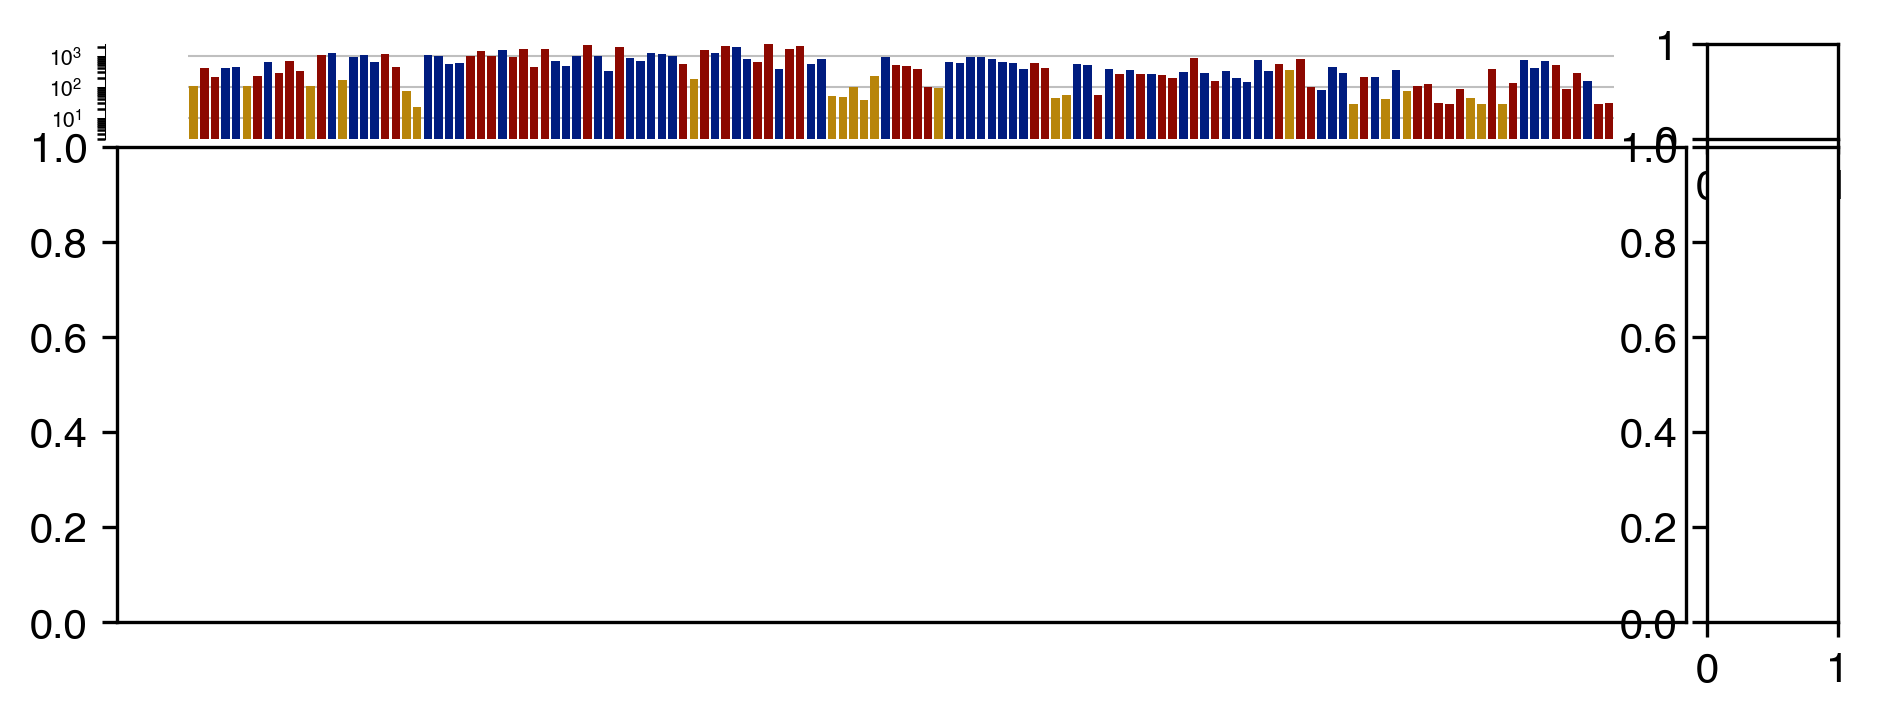

In [22]:
yvals = np.cumsum(
    syn_table_noitc.groupby("consensus_label").count()["cell_type_pre"]
).values

fig, axes = plt.subplots(
    figsize=(7.4, 2.5),
    nrows=2,
    ncols=2,
    gridspec_kw={
        "height_ratios": [1, 5],
        "hspace": 0.025,
        "width_ratios": [12,1],
        "wspace": 0.025,
    },
    dpi=300,
)

ax = axes[0,0]
ax.set_visible(True)
ax.bar(
    x=np.arange(len(syn_table_noitc)) + 0.5,
    height=syn_table_noitc.sort_values(by=["consensus_label", "soma_depth_pre"])[
        "net_syn"
    ],
    color=[
        ctype_hues[x]
        for x in syn_table_noitc.sort_values(by=["consensus_label", "soma_depth_pre"])[
            "cell_type_pre"
        ]
    ],
    alpha=1,
    width=0.8,
)

ax.set_ylim(2, 2400)
ax.yaxis.set_ticks_position("left")
ax.set_yticks([10, 100, 1000])
sns.despine(ax=ax, offset=3)
_ = ax.set_yticklabels(["10$^1$", "10$^2$", "10$^3$"], fontdict={"fontsize": 5})
ax.set_yscale("log")
ax.hlines(
    [10, 100, 1000],
    0,
    len(syn_table_noitc),
    linewidth=0.5,
    color=(0.5, 0.5, 0.5),
    alpha=0.5,
    zorder=-10,
)
ax.tick_params(length=2, width=0.25, axis="y")
ax.tick_params(length=0, width=0, axis="x")
# ax.invert_yaxis()
ax.set_xticks([])
ax.set_xlabel(None)

ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(0.25)
ax.spines["top"].set_linewidth(0.25)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(rotation=0)

ax = axes[1,0]
ax.sharex(axes[0,0])
sns.heatmap(
    syn_table_noitc_norm.sort_values(by=["consensus_label", "soma_depth_pre"])[
        ct_list_exc
    ].T,
    # square=True,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=0.4,
    ax=ax,
    cbar=False,
)
ax.vlines(yvals, 0, len(ct_list_exc), color="w", linewidth=1)
ax.hlines(
    [3, 5, 8, 12, 14, 17, len(ct_list_exc)],
    0,
    len(syn_table),
    color="w",
    linewidth=1,
    alpha=0.75,
)

_ = ax.set_xticks([])

ax.set_xticks(np.concatenate(([0], yvals[0:-1])) + 0.6)
ax.set_xticklabels(
    np.arange(len(syn_table_noitc["consensus_label"].unique())),
    fontdict={"fontsize": 5, 'rotation': 0},
)

ax.tick_params(length=2, width=0.5, axis="y")
ax.tick_params(length=0, width=0, axis="x")

ax.set_yticks(np.arange(len(ct_list_exc)) + 0.5)
ax.set_yticklabels(ct_list_exc, rotation=0, fontdict={"size": 4})
ax.set_xlabel("")

blank_ax = axes[0,1]
blank_ax.set_visible(False)

ax = axes[1,1]
sns.histplot(
    y='hlabel',
    data=dfct_e,
    edgecolor='w',
    hue='hlabel',
    palette=ctype_hues,
    alpha=1,
    legend=False,
    ax=ax,
    shrink=0.8,
)
ax.set_ylim(np.array(axes[1,0].get_ylim())-0.5)
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xticks([0,50,100,150])
ax.vlines(
    [50, 100, 150],
    0,
    syn_table_noitc.shape[0],
    linewidth=0.5,
    color=(0.5, 0.5, 0.5),
    alpha=0.5,
    zorder=-10,
)
sns.despine(ax=ax, offset=3, left=True, right=True, top=True, bottom=False, trim=True)
ax.set_xlabel('Num. Cell', fontdict={'size': 5})
ax.xaxis.set_tick_params(length=2)
ax.set_xticklabels([0,50,100,150], fontdict={'size': 5})

fig.savefig(
    f"{plot_dir}/target_distribitions_no_itc_horiz_bars.pdf", bbox_inches="tight"
)

In [ ]:
syn_table_select = pd.concat([syn_table_noitc, syn_table_itc])

In [ ]:
ct_list_exc = list(ct_list_exc)

In [ ]:
yvals=np.cumsum(syn_table_select.groupby('consensus_label').count()['cell_type_pre']).values

fig, axes = plt.subplots(
    figsize=(4,20),
    ncols=2,
    sharey=True,
    dpi=300,
    gridspec_kw={"width_ratios": [6, 2], "wspace": 0},
)

ax = axes[0]
sns.heatmap(
    syn_table_select.sort_values(by=["consensus_label", "soma_depth_pre"])[ct_list_norm],
    # syn_table_select.sort_values(by=["cl_label", "soma_depth_pre"])[ct_list_norm[:-4]] / (e_cell_count / np.mean(e_cell_count)).values.T,
    square=True,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=0.4,
    ax=ax,
    cbar=False,
    # cbar=True,
    # cbar_kws={"shrink": 0.25},
)
ax.hlines(yvals, 0, len(ct_list_norm), color="w", linewidth=1)
ax.vlines( [3, 6, 9, 13, 15, 18, len(ct_list_exc)], 0, len(syn_table), color="w", linewidth=1, alpha=0.75)
_ = ax.set_yticks([])

ax.set_yticks(np.concatenate(([0], yvals[0:-1]))+0.5)
ax.set_yticklabels(np.arange(len(syn_table_select['consensus_label'].unique())), fontdict={'fontsize': 6})
ax.xaxis.set_ticks_position("top")
ax.tick_params(length=2, width=0.5, axis='x')
ax.tick_params(length=0, width=0, axis='y')
ax.set_xticks(np.arange(len(ct_list_norm)) + 0.5)
ax.set_xticklabels(ct_list_exc + ct_list_inh, rotation=90, fontdict={"size": 4})
ax.set_ylabel("")

ax = axes[1]
ax.set_visible(True)
ax.barh(
    y=np.arange(len(syn_table_select)) + 0.5,
    width=syn_table_select.sort_values(by=["consensus_label", "soma_depth_pre"])["net_syn"],
    color=[
        ctype_hues[x] for x in syn_table_select.sort_values(by=["consensus_label", "soma_depth_pre"])["cell_type_pre"]
    ],
    alpha=0.8,
    height=0.6,
)
ax.set_xlim(2, 2400)
ax.xaxis.set_ticks_position("top")
ax.set_xticks([10, 100, 1000])
_ = ax.set_xticklabels(["10$^1$", "10$^2$", "10$^3$"], fontdict={"fontsize": 5})
ax.set_xscale("log")
ax.vlines([10, 100, 1000], 0, len(syn_table_select), linewidth=0.5, color=(0.5, 0.5, 0.5), alpha=0.5, zorder=-10)
ax.tick_params(length=2, width=0.25, axis='x')
ax.tick_params(length=0, width=0, axis='y')

ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(0.25)
ax.spines["top"].set_linewidth(0.25)

fig.savefig(f'{plot_dir}/target_distribitions_supplement_nocolorbar.pdf', bbox_inches='tight')

# fig.savefig('plots/target_distribitions_colorbar.pdf', bbox_inches='tight')

In [193]:
# syn_table_select.reset_index(drop=True).to_feather(f"{data_dir}/inhibitory_motif_table.feather")

In [29]:
syn_table_select = pd.read_feather(f"{data_dir}/inhibitory_motif_table.feather")

In [30]:
syn_table_noitc = syn_table_select.query('cell_type_pre!="ITC"')

In [31]:
syn_table_long = syn_table_noitc.melt(
    id_vars = ['pre_pt_root_id', 'cell_type_pre', 'consensus_label', 'soma_depth_pre'],
    value_vars = ct_list_exc,
    value_name = 'frac_syn',
)

ct_norm_list = {f"{ct}": ii for ii, ct in enumerate(ct_list_exc)}

syn_table_long['post_idx'] = syn_table_long['variable'].replace(ct_norm_list)

In [32]:
syn_table_noitc_eonly = syn_table_noitc.copy()
syn_table_noitc_eonly[ct_list_exc] = np.divide(syn_table_noitc[ct_list_exc].values, np.atleast_2d(syn_table_noitc[ct_list_exc].sum(axis=1).values).T)

In [33]:
syn_table_long = syn_table_noitc_eonly.melt(
    id_vars = ['pre_pt_root_id', 'cell_type_pre', 'consensus_label', 'soma_depth_pre'],
    value_vars = ct_list_exc,
    value_name = 'frac_syn',
)

ct_norm_list = {f"{ct}": ii for ii, ct in enumerate(ct_list_exc)}

syn_table_long['post_idx'] = syn_table_long['variable'].replace(ct_norm_list)

In [35]:
syn_table_long.

,pre_pt_root_id,cell_type_pre,consensus_label,soma_depth_pre,variable,frac_syn,post_idx
0,864691134886015738,DTC,13,616.294445,L2a,0.000000,0
1,864691134886016762,DTC,4,417.396166,L2a,0.000881,0
2,864691134948652540,PTC,9,534.872300,L2a,0.000000,0
3,864691135013445270,STC,6,339.903685,L2a,0.000000,0
4,864691135082074103,DTC,14,647.991723,L2a,0.000000,0
...,...,...,...,...,...,...,...
2407,864691136926560074,PTC,4,537.311346,L6wm,0.000000,17
2408,864691136966961614,PTC,8,498.168954,L6wm,0.000000,17
2409,864691136990457749,STC,14,675.913094,L6wm,0.074074,17
2410,864691137020205166,STC,15,583.731916,L6wm,0.071429,17


In [36]:
(
    syn_table_long.query('consensus_label<=18').groupby(["consensus_label", "post_idx", "variable"])
    .median("frac_syn")[["frac_syn"]]
    .reset_index()
).to_clipboard()

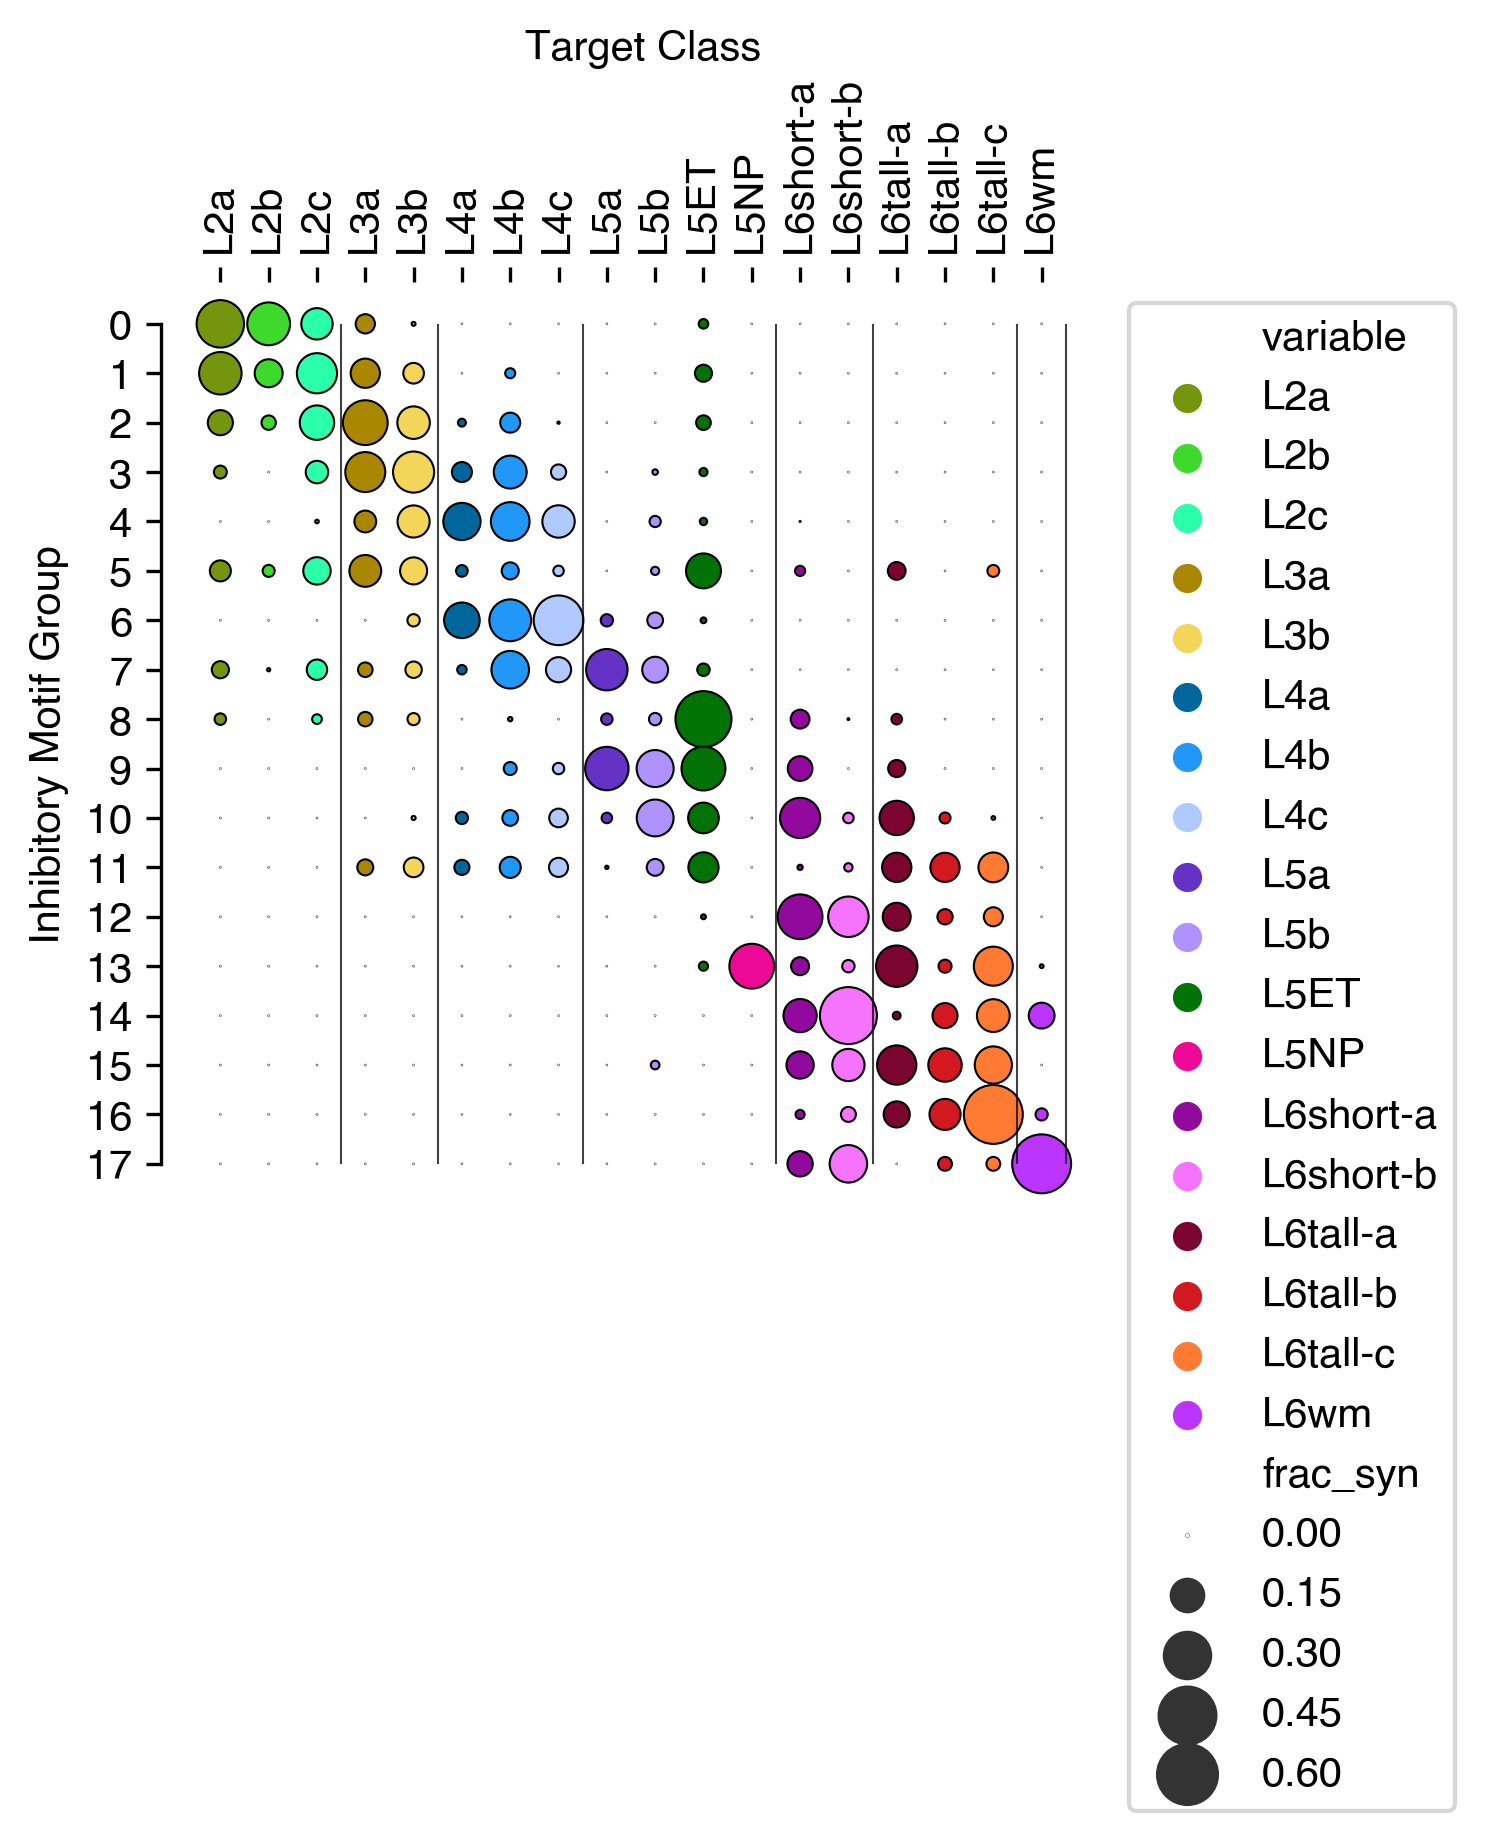

In [247]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

sns.scatterplot(
    x="post_idx",
    y="consensus_label",
    size="frac_syn",
    size_norm=(0.01, 0.5),
    sizes=(0.01, 200),
    hue="variable",
    palette=ctype_hues,
    data=syn_table_long.query('consensus_label<=18').groupby(["consensus_label", "post_idx", "variable"])
    .median("frac_syn")[["frac_syn"]]
    .reset_index(),
    edgecolor="k",
    marker='o',
    linewidth=0.5,
    ax=ax,
    legend=True,
)

ax.invert_yaxis()
ax.set_yticks(np.arange(syn_table_long.query('consensus_label<18')["consensus_label"].max() + 1))
ax.legend().set_bbox_to_anchor((1,1))
ax.vlines(
    np.array( [3, 5, 8, 12, 14, 17, len(ct_list_exc)])-0.5,
    0,
    syn_table_long.query('consensus_label<=18')["consensus_label"].max(),
    color="k",
    linewidth=0.5,
    alpha=0.75,
)


ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xticks(np.arange(len(ct_list_exc )))

ax.set_xlabel('Target Class')
ax.set_ylabel('Inhibitory Motif Group')

_ = ax.set_xticklabels(ct_list_exc , rotation=90)
sns.despine(ax=ax, offset=4, trim=True, top=True, bottom=True)
# fig.savefig(f"{plot_dir}/inhibitory_motif_output_fraction_scatter.pdf", bbox_inches="tight")

In [26]:
syn_table_long

NameError: name 'syn_table_long' is not defined

In [37]:
(
    syn_table_long.query("consensus_label<19")
    .groupby(["consensus_label", "post_idx", "variable"])
    .frac_syn
    .mean()
)

consensus_label  post_idx  variable 
0                0         L2a          0.395975
                 1         L2b          0.267352
                 2         L2c          0.160467
                 3         L3a          0.063741
                 4         L3b          0.014200
                                          ...   
17               13        L6short-b    0.208577
                 14        L6tall-a     0.000000
                 15        L6tall-b     0.037037
                 16        L6tall-c     0.037037
                 17        L6wm         0.616959
Name: frac_syn, Length: 324, dtype: float64

In [261]:
frac_bins = [-1, 0.05, 0.15, 0.3, 1]

syn_long_dis = (
    syn_table_long.query("consensus_label<19")
    .groupby(["consensus_label", "post_idx", "variable"])
    ['frac_syn']
    .mean()
).reset_index()

syn_long_dis['frac_syn_dis'] = pd.cut(syn_long_dis['frac_syn'], frac_bins, labels=np.arange(len(frac_bins)-1))

In [201]:
# syn_table_noitc_eonly = syn_table_noitc.copy()
# syn_table_noitc_eonly[ct_list_exc] = np.divide(syn_table_noitc[ct_list_exc].values, np.atleast_2d(syn_table_noitc[ct_list_exc].sum(axis=0).values))

# syn_table_long = syn_table_noitc_eonly.melt(
#     id_vars = ['pre_pt_root_id', 'cell_type_pre', 'consensus_label', 'soma_depth_pre'],
#     value_vars = ct_list_exc,
#     value_name = 'frac_syn',
# )
# ct_norm_list = {f"{ct}": ii for ii, ct in enumerate(ct_list_exc)}
# syn_table_long['post_idx'] = syn_table_long['variable'].replace(ct_norm_list)

In [202]:
syn_long_dis.pivot_table(
    index='consensus_label',
    columns='variable',
    values='frac_syn',
    aggfunc='sum',
)

variable,L2a,L2b,L2c,L3a,L3b,L4a,L4b,L4c,L5ET,L5NP,L5a,L5b,L6short-a,L6short-b,L6tall-a,L6tall-b,L6tall-c,L6wm
consensus_label,,,,,,,,,,,,,,,,,,
0,4.355730,2.940869,1.765140,0.701149,0.156202,0.016476,0.082856,0.029051,0.567385,0.009212,0.148424,0.030886,0.008097,0.011478,0.060814,0.011108,0.089693,0.015430
1,2.356463,1.148137,2.090943,1.250007,0.588655,0.090205,0.269906,0.084151,0.510092,0.030039,0.192672,0.096547,0.043273,0.022374,0.132924,0.022022,0.071590,0.000000
2,1.431716,0.620731,2.676877,3.996760,2.137968,0.340121,0.874031,0.254045,0.708586,0.013096,0.241919,0.136200,0.074675,0.040780,0.213607,0.115212,0.123677,0.000000
3,0.482624,0.138855,1.174391,2.646211,3.720371,0.918518,2.407144,0.559466,0.373059,0.009537,0.156527,0.213583,0.086977,0.010549,0.033853,0.010671,0.057104,0.000560
4,0.099509,0.025491,0.209325,1.064398,2.124373,2.662454,3.036473,2.081140,0.296136,0.007164,0.190185,0.479896,0.467510,0.026696,0.122460,0.055030,0.044992,0.006770
5,0.732238,0.367890,1.134833,1.455073,1.198276,0.481177,0.555415,0.432766,1.890459,0.090789,0.145970,0.191598,0.258570,0.065791,0.556540,0.080429,0.362186,0.000000
6,0.000000,0.000000,0.005871,0.148285,0.219409,1.557849,1.914870,2.969187,0.229435,0.001754,0.307628,0.392775,0.042403,0.016667,0.097732,0.053229,0.042907,0.000000
7,0.145011,0.031280,0.142357,0.119915,0.148571,0.113423,0.609536,0.301840,0.122299,0.003817,0.895565,0.278764,0.040017,0.011391,0.013359,0.006650,0.016206,0.000000
8,0.720889,0.203142,0.564370,0.768031,0.694976,0.210009,0.300474,0.254436,8.619989,0.043205,0.548786,0.837474,0.919567,0.191079,0.766284,0.153647,0.200638,0.003003


Text(0, 0.5, 'Inhibitory Motif Group')

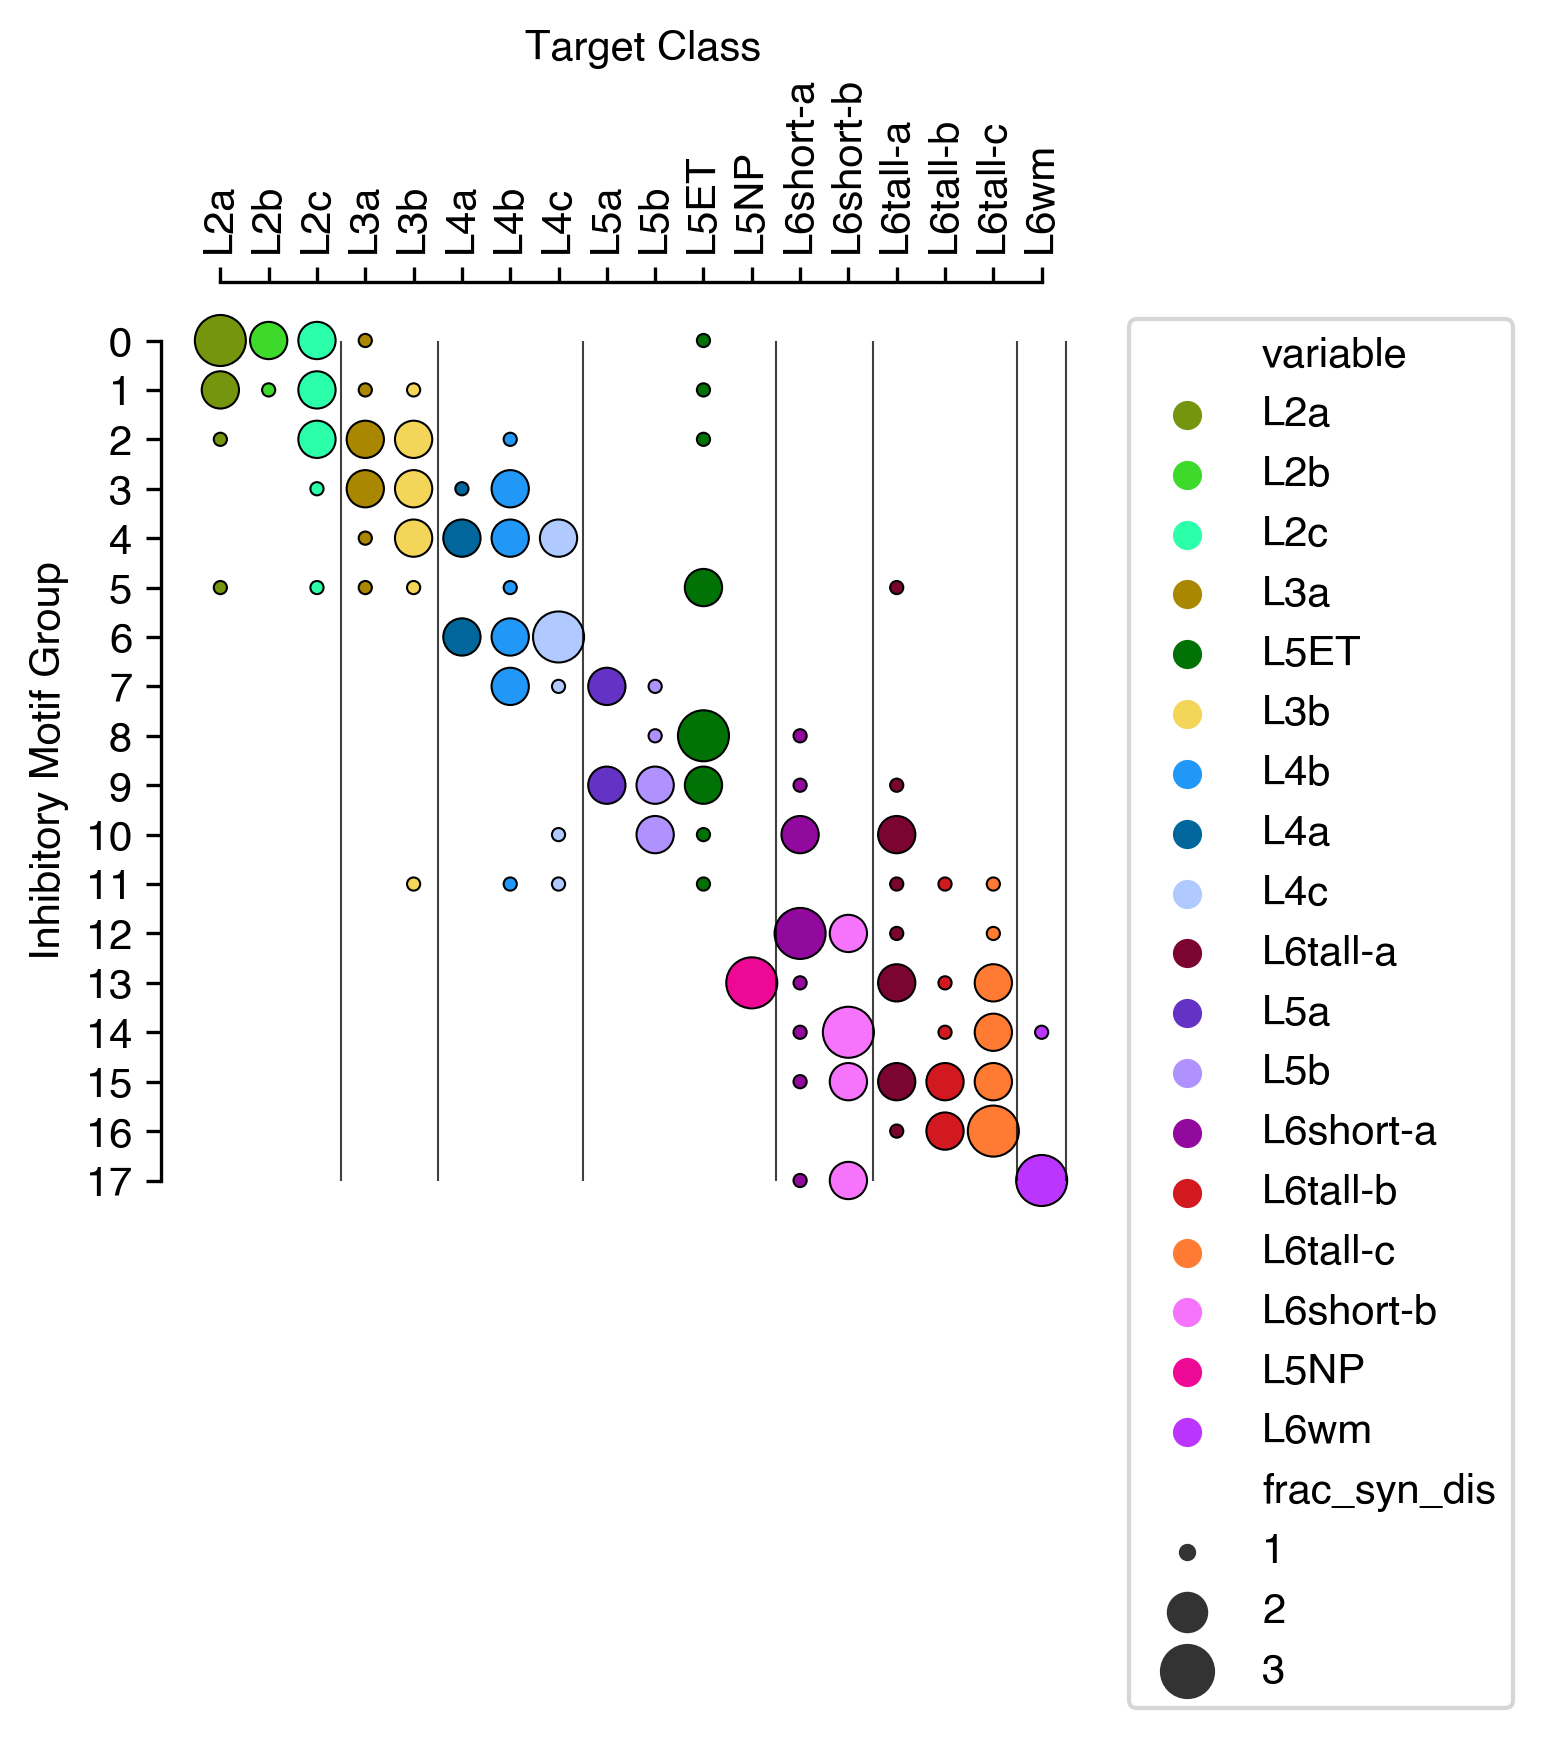

In [263]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

sns.scatterplot(
    x="post_idx",
    y="consensus_label",
    size="frac_syn_dis",
    size_norm=(1,3),
    sizes=(10, 150),
    hue="variable",
    palette=ctype_hues,
    data=syn_long_dis.query('frac_syn_dis>0'),
    edgecolor="k",
    marker='o',
    linewidth=0.5,
    ax=ax,
    legend=True,
)

ax.invert_yaxis()
ax.set_yticks(np.arange(syn_table_long.query('consensus_label<19')["consensus_label"].max() + 1))
ax.legend().set_bbox_to_anchor((1,1))
ax.vlines(
    np.array([3, 5, 8, 12, 14, 17, len(ct_list_exc)])-0.5,
    0,
    syn_table_long.query('consensus_label<19')["consensus_label"].max(),
    color="k",
    linewidth=0.5,
    alpha=0.75,
)

ax.set_xticks(np.arange(len(ct_list_exc)))

sns.despine(ax=ax, offset=4, trim=True, top=False, bottom=True)
_ = ax.set_xticklabels(ct_list_exc, rotation=90)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xlabel('Target Class')
ax.set_ylabel('Inhibitory Motif Group')

# fig.savefig(f"{plot_dir}/inhibitory_motif_output_fraction_scatter_cartoon_legend.pdf", bbox_inches="tight")
# ax.legend().set_visible(False)
# fig.savefig(f"{plot_dir}/inhibitory_motif_output_fraction_scatter_cartoon.pdf", bbox_inches="tight")

In [284]:
label_table_in_long.head()

,consensus_label,variable,frac_syn,post_idx,frac_syn_dis
0,0,L2a,0.249515,0,2
1,1,L2a,0.327279,0,3
2,2,L2a,0.232587,0,2
3,3,L2a,0.079351,0,1
4,4,L2a,0.014283,0,0


In [286]:
paired_df = syn_long_dis.merge(
    label_table_in_long[['consensus_label', 'variable', 'frac_syn']].rename(columns={'frac_syn': 'frac_syn_in'}),
    on=['consensus_label', 'variable'],
)

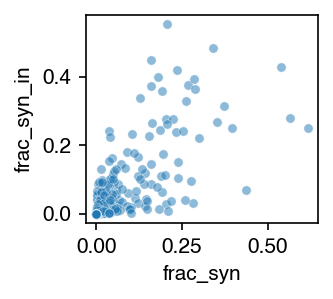

In [295]:
fig, ax = plt.subplots(figsize=(2,2), dpi=150)
sns.scatterplot(
    x='frac_syn',
    y='frac_syn_in',
    # hue='variable',
    # palette=ctype_hues,
    data=paired_df,
    s=20,
    alpha=0.5,
    ax=ax,
)

ax.set_aspect('equal')

ValueError: operands could not be broadcast together with shapes (18,) (4,) 

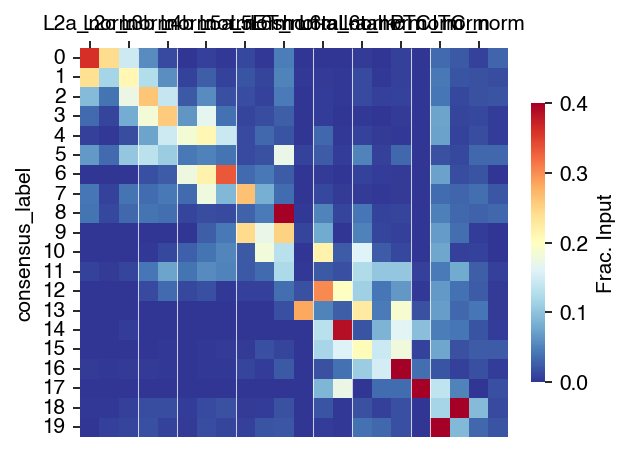

In [39]:
label_syn_table = syn_table_select.groupby("consensus_label")[ct_list_exc].sum()

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
sns.heatmap(
    syn_table_select.groupby("consensus_label")[ct_list_norm].mean(),
    cmap="RdYlBu_r",
    ax=ax,
    square=True,
    vmax=0.4,
    vmin=0,
    cbar_kws={"fraction": 0.03, "label": "Frac. Input"},
)

ax.vlines( [3, 5, 8, 12, 14, 17, len(ct_list_exc)], 0, len(syn_table), color="w", linewidth=0.5, alpha=0.75)

ax.xaxis.set_ticks_position("top")
ax.set_xticks(np.arange(len(ct_list_exc + ct_list_inh))+0.5)
ax.set_xticklabels(ct_list_exc + ct_list_inh, rotation=90, fontdict={'fontsize': 6})
ax.set_yticklabels(np.arange(len(syn_table_select['consensus_label'].unique())), rotation=0)
_ = ax.set_ylabel("Inhibtory Motif Group")

# fig.savefig(f"{plot_dir}/inhibitory_motif_output_fraction.pdf", bbox_inches="tight")
# (label_syn_table / label_syn_table.values.sum(axis=0)).to_csv(
#     f"{plot_data_dir}/inhibitory_motif_output_fraction.csv"
# )

In [43]:
list(ct_list_exc) + ct_list_inh

['L2a',
 'L2b',
 'L2c',
 'L3a',
 'L3b',
 'L4a',
 'L4b',
 'L4c',
 'L5a',
 'L5b',
 'L5ET',
 'L5NP',
 'L6short-a',
 'L6short-b',
 'L6tall-a',
 'L6tall-b',
 'L6tall-c',
 'L6wm',
 'PTC',
 'DTC',
 'ITC',
 'STC']

---

In [44]:
label_syn_table_in = syn_table_select.query('consensus_label<18').groupby("consensus_label")[ct_list_exc].sum()
label_syn_table_in = label_syn_table / label_syn_table.values.sum(axis=0)

label_table_in_long = label_syn_table_in.reset_index().melt(
    id_vars = 'consensus_label',
    value_vars = ct_list_exc,
    value_name = 'frac_syn',
)


label_table_in_long['post_idx'] = label_table_in_long['variable'].replace(
    {ct:ii for ii, ct in enumerate(list(ct_list_exc) + ct_list_inh)}
)

In [50]:
label_table_in_long.query('consensus_label<19').sort_values(by='consensus_label').to_clipboard()

In [274]:
label_table_in_long['frac_syn_dis'] = pd.cut(label_table_in_long['frac_syn'], frac_bins, labels=np.arange(len(frac_bins)-1))

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


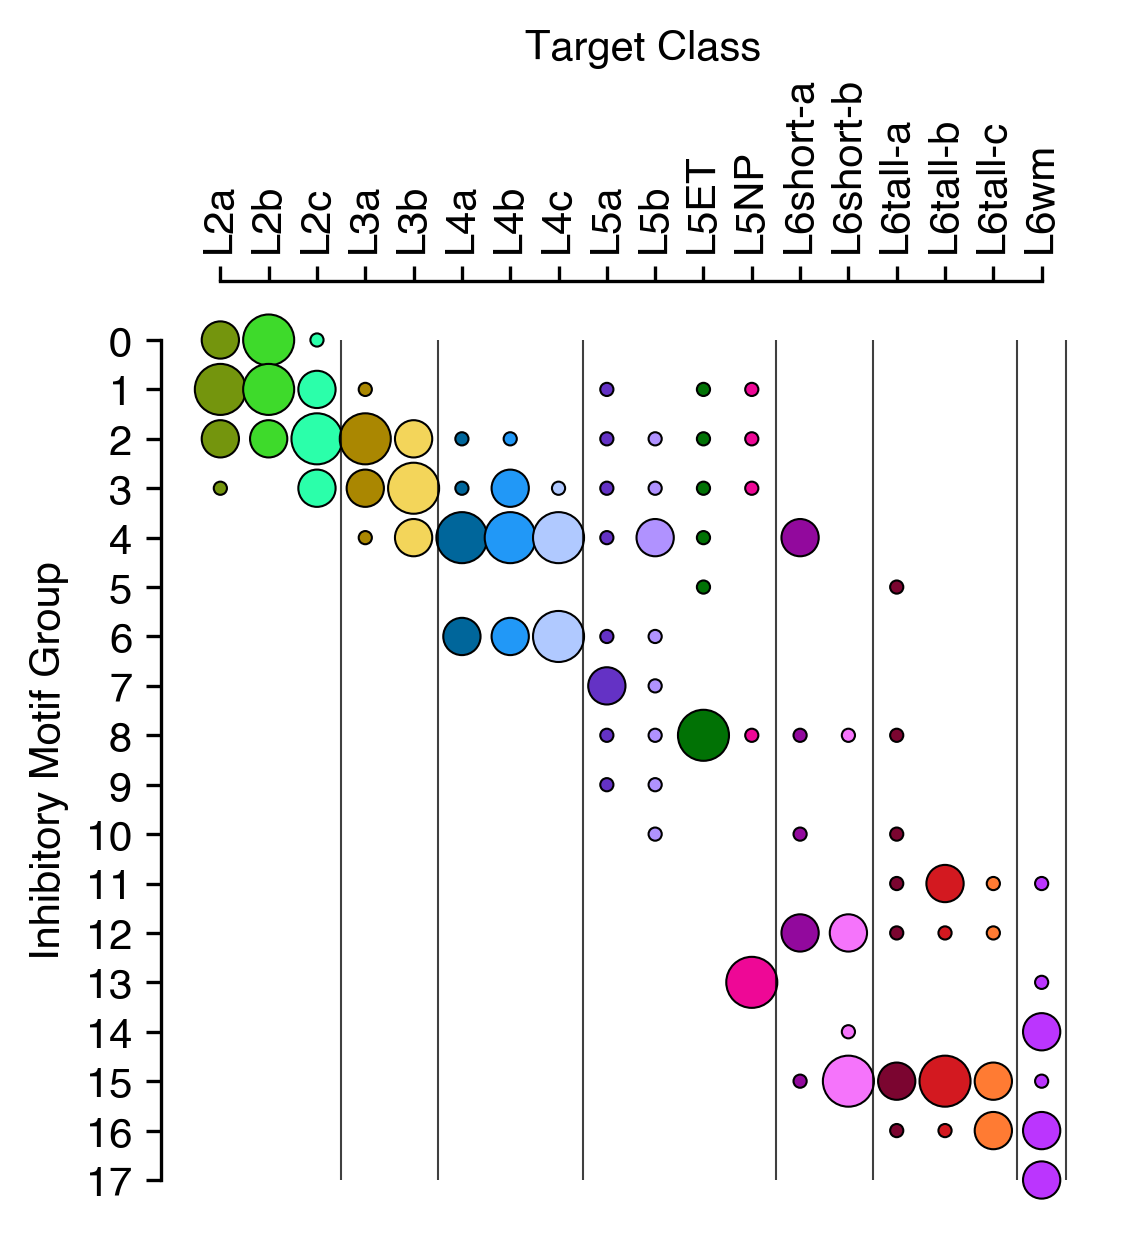

In [282]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

sns.scatterplot(
    x="post_idx",
    y="consensus_label",
    size="frac_syn_dis",
    size_norm=(1,3),
    sizes=(10, 150),
    hue="variable",
    palette=ctype_hues,
    data=label_table_in_long.query('frac_syn_dis>0'),
    edgecolor="k",
    marker='o',
    linewidth=0.5,
    ax=ax,
    legend=True,
)

ax.invert_yaxis()
ax.set_yticks(np.arange(label_table_in_long.query('consensus_label<19')["consensus_label"].max() + 1))
ax.legend().set_bbox_to_anchor((1,1))
ax.vlines(
    np.array([3, 5, 8, 12, 14, 17, len(ct_list_exc)])-0.5,
    0,
    syn_table_long.query('consensus_label<19')["consensus_label"].max(),
    color="k",
    linewidth=0.5,
    alpha=0.75,
)

ax.set_xticks(np.arange(len(ct_list_exc)))

sns.despine(ax=ax, offset=4, trim=True, top=False, bottom=True)
_ = ax.set_xticklabels(ct_list_exc, rotation=90)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xlabel('Target Class')
ax.set_ylabel('Inhibitory Motif Group')

fig.savefig(f"{plot_dir}/inhibitory_motif_input_fraction_scatter_cartoon_legend.pdf", bbox_inches="tight")
ax.legend().set_visible(False)
fig.savefig(f"{plot_dir}/inhibitory_motif_input_fraction_scatter_cartoon.pdf", bbox_inches="tight")

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (18).

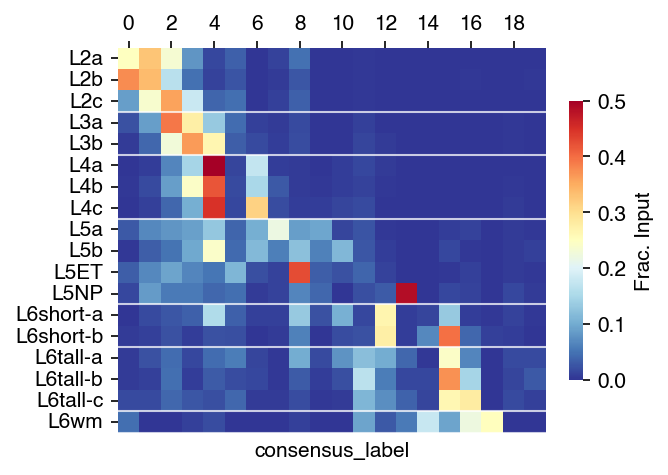

In [280]:
n_cl = 20
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
sns.heatmap(
    (label_syn_table / label_syn_table.values.sum(axis=0)).T,
    cmap="RdYlBu_r",
    ax=ax,
    square=True,
    vmax=0.5,
    vmin=0,
    cbar_kws={"fraction": 0.03, "label": "Frac. Input"},
)

ax.hlines(
     [3, 5, 8, 12, 14, 17, len(ct_list_exc)], 0, len(syn_table), color="w", linewidth=1, alpha=0.75)

ax.xaxis.set_ticks_position("top")
ax.set_yticks(np.arange(len(ct_list_exc))+0.5)
ax.set_yticklabels(ct_list_exc, rotation=0)
ax.set_xticklabels(np.arange(n_cl-2), rotation=0)
_ = ax.set_xlabel("Motif Group")

# fig.savefig(f"{plot_dir}/inhibitory_motif_input_fraction.pdf", bbox_inches="tight")
# (label_syn_table / label_syn_table.values.sum(axis=0)).to_csv(
#     f"{plot_data_dir}/inhibitory_motif_input_fraction.csv"
# )

In [ ]:
frac_bins = [-1, 0.05, 0.15, 0.3, 1]

syn_long_dis = (
    syn_table_long.query("consensus_label<19")
    .groupby(["consensus_label", "post_idx", "variable"])
    .mean("frac_syn")
)['frac_syn'].reset_index()

syn_long_dis['frac_syn_dis'] = pd.cut(syn_long_dis['frac_syn'], frac_bins, labels=np.arange(len(frac_bins)-1))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

sns.scatterplot(
    x="post_idx",
    y="consensus_label",
    size="frac_syn_dis",
    size_norm=(1,3),
    sizes=(10, 150),
    hue="variable",
    palette=ctype_hues,
    data=syn_long_dis.query('frac_syn_dis>0'),
    edgecolor="k",
    marker='o',
    linewidth=0.5,
    ax=ax,
    legend=True,
)

ax.invert_yaxis()
ax.set_yticks(np.arange(syn_table_long.query('consensus_label<19')["consensus_label"].max() + 1))
ax.legend().set_bbox_to_anchor((1,1))
ax.vlines(
    np.array([3, 5, 8, 12, 14, 17, len(ct_list_exc)])-0.5,
    0,
    syn_table_long.query('consensus_label<19')["consensus_label"].max(),
    color="k",
    linewidth=0.5,
    alpha=0.75,
)

ax.set_xticks(np.arange(len(ct_list_exc)))

sns.despine(ax=ax, offset=4, trim=True, top=False, bottom=True)
_ = ax.set_xticklabels(ct_list_exc, rotation=90)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xlabel('Target Class')
ax.set_ylabel('Inhibitory Motif Group')

# fig.savefig(f"{plot_dir}/inhibitory_motif_output_fraction_scatter_cartoon_legend.pdf", bbox_inches="tight")
# ax.legend().set_visible(False)
# fig.savefig(f"{plot_dir}/inhibitory_motif_output_fraction_scatter_cartoon.pdf", bbox_inches="tight")

In [ ]:
input_frac_df = label_syn_table / label_syn_table.values.sum(axis=0)

In [ ]:
input_frac_df

---

In [ ]:
syn_amplitude_df = syn_df.groupby(['cell_type_post']).count()[['id']].rename(columns={'id': 'num_syn'})

In [ ]:
syn_amplitude_df

weights = (syn_amplitude_df / syn_amplitude_df.mean())**-1

In [ ]:
st_rows = np.array_split(syn_table_select.sort_values(by='soma_depth_pre'), 12)
for ii, syn_table_sp in enumerate(st_rows):
    fig, ax = plt.subplots(figsize=(2*len(syn_table_sp), 4), dpi=300)
    plot_cell_lineup(
        syn_table_sp.reset_index(),
        ax=ax,
        root_id="pre_pt_root_id",
        hue='cell_type_pre',
        palette=ctype_hues,
        axon_anno='is_axon',
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm
    )
    ax.set_ylim(*height_bounds[::-1])
    plt.tight_layout()
    sns.despine(ax=ax, top=True, bottom=True, right=True)
    fig.savefig(f'{plot_dir}/connectivity_pattern_morpho_multirow_{ii}.pdf', bbox_inches='tight')

In [ ]:
n_cluster = len(syn_table_select['consensus_label'].unique())

for ct in np.arange(n_cluster):
    syn_table_sp = syn_table_select.query("consensus_label == @ct").sort_values(by='soma_depth_pre').reset_index()
    fig, ax = plt.subplots(figsize=(4*len(syn_table_sp), 4), dpi=300)
    plot_cell_lineup(
        syn_table_sp,
        ax=ax,
        root_id="pre_pt_root_id",
        hue='cell_type_pre',
        palette=ctype_hues,
        axon_anno='is_axon',
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
    )
    ax.set_ylim(*height_bounds[::-1])
    sns.despine(ax=ax, top=True, bottom=True, right=True)
    plt.tight_layout()
    fig.savefig(f'{plot_dir}/connectivity_pattern_morpho_con_ct_{ct}.pdf')

In [53]:
1

1

In [54]:
syn_table_select['consensus_label']=syn_table_select['consensus_label']+1

In [56]:
(
    syn_table_select
    .query('consensus_label < 19')
    [['consensus_label', 'soma_depth_pre', 'cell_type_pre']].sort_values(by='consensus_label')
).to_clipboard()

/Users/caseysm/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


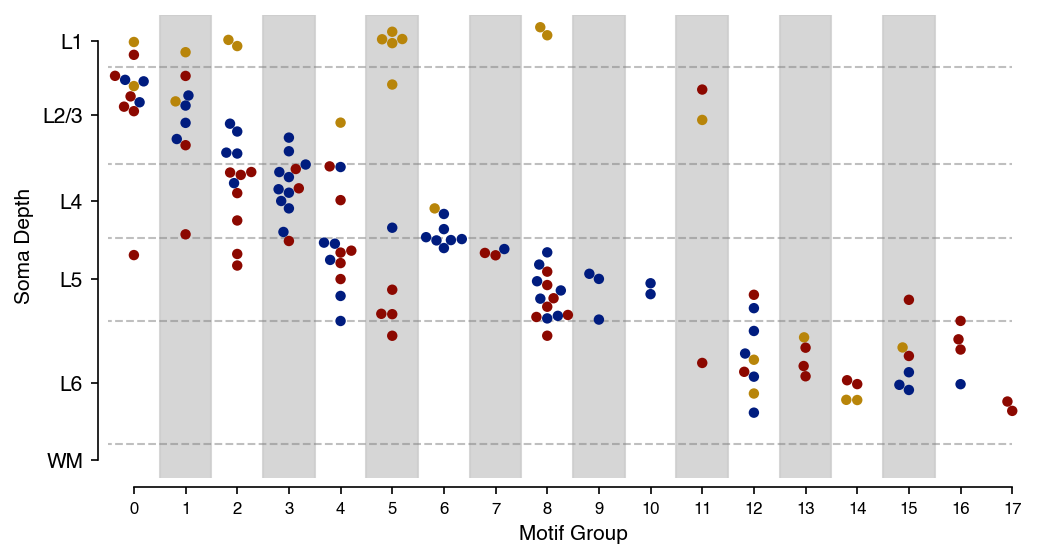

In [51]:

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
sns.swarmplot(
    x="consensus_label",
    y='soma_depth_pre',
    hue="cell_type_pre",
    data=syn_table_select.query('consensus_label < 19'),
    palette=ctype_hues,
    ax=ax,
    size=5,
    edgecolor='w',
    legend=False,
)

ax.set_ylim(*height_bounds)
ax.invert_yaxis()

plotting_code.plot_layers(
    layer_bounds,
    depth_bounds=height_bounds-[0, 140],
    span=(-1,17),
    ax=ax,
    linestyle="--",
    color=(0.5, 0.5, 0.5),
    alpha=0.5,
    linewidth=1,
)


ax.set_xticks(np.arange(18))
ax.set_xlim(-0.5, 17.5)
sns.despine(ax=ax, offset=5, trim=True)
ax.legend().set_visible(None)
ax.set_xlabel('Motif Group')
ax.xaxis.set_tick_params(labelsize=8)
ax.set_ylabel('Soma Depth')

for ii in np.arange(0, 16,2)+1:
    ax.fill_between(
        ii+np.array([-0.5,0.5]),
        height_bounds[0] * np.array([1,1]),
        height_bounds[1] * np.array([1,1]),
        zorder=-50,
        color=(0.8, 0.8, 0.8),
        alpha=0.8,
    )
# fig.savefig(f"{plot_dir}/motif_group_composition_scatter.pdf", bbox_inches='tight')


In [ ]:
st_bar = syn_table_select.query('consensus_label < 18').groupby(["consensus_label", "cell_type_pre"]).count()[
    "L2a"
].reset_index()
st_bar['cell_type_pre'] = st_bar['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh[::-1], ordered=True))

fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
sns.histplot(
    x="consensus_label",
    hue="cell_type_pre",
    weights="L2a",
    data=st_bar,
    multiple="stack",
    palette=ctype_hues,
    ax=ax,
    discrete=True,
    shrink=0.8,
    linewidth=0.5,
    edgecolor='w',
)

ax.set_xticks(np.arange(18))
ax.set_ylim(0, 23)
ax.set_yticks([0,5,10,15, 20])
sns.despine(ax=ax, offset=5, trim=True)
ax.legend().set_visible(None)
ax.set_xlabel('Motif Group')
ax.xaxis.set_tick_params(labelsize=8)

fig.savefig(f"{plot_dir}/motif_group_composition.pdf", bbox_inches='tight')


In [ ]:
for ct in np.arange(n_cluster):
    syn_table_sp = syn_table_select.query("consensus_label == @ct").sample(
        n=np.min((len(syn_table_select.query("consensus_label == @ct")), 3)),
    ).sort_values(by=['consensus_label', 'soma_depth_pre'])

    fig, ax = plt.subplots(figsize=(4*len(syn_table_sp), 4), dpi=300)
    plot_cell_lineup(
        syn_table_sp,
        ax=ax,
        root_id="pre_pt_root_id",
        hue='cell_type_pre',
        palette=ctype_hues,
        axon_anno='is_axon',
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
    )
    ax.set_ylim(*height_bounds[::-1])
    sns.despine(ax=ax, bottom=True, trim=True)
    # plt.tight_layout()
    fig.savefig(f'{plot_dir}/connectivity_pattern_sample_morpho_con_ct_{ct}.pdf')

for ct in np.arange(n_cluster):
    syn_table_sp = syn_table_select.query("consensus_label == @ct").sort_values(by='soma_depth_pre').reset_index()
    fig, ax = plt.subplots(figsize=(4*len(syn_table_sp), 4), dpi=300)
    plot_cell_lineup(
        syn_table_sp,
        ax=ax,
        root_id="pre_pt_root_id",
        hue='cell_type_pre',
        palette=ctype_hues,
        axon_anno='is_axon',
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
    )
    ax.set_ylim(*height_bounds[::-1])
    # plt.tight_layout()
    fig.savefig(f'{plot_dir}/connectivity_pattern_morpho_con_ct_{ct}.pdf')

Matrix plots

In [ ]:
pitc_root_ids = syn_table_select.query('consensus_label==19').pre_pt_root_id

In [ ]:
vip_target_df = (
    syn_df.query('cell_type_pre ==  "ITC" and cell_type_post == "DTC" and pre_pt_root_id not in @pitc_root_ids')
    .groupby(["pre_pt_root_id", "post_pt_root_id"])
    .count()[["id"]]
    .rename(columns={"id": "num_syn"})
    .reset_index()
)

vip_target_df = vip_target_df.merge(
    syn_df.drop_duplicates("post_pt_root_id")[["post_pt_root_id", "soma_depth_post"]],
    on="post_pt_root_id",
    how="left",
).sort_values(by="num_syn", ascending=False).merge(
    syn_df.drop_duplicates("pre_pt_root_id")[["pre_pt_root_id", "soma_depth_pre"]],
    on="pre_pt_root_id",
    how="left",
).sort_values(
    by="num_syn", ascending=False
)

vip_target_df['pre_x'] = 0

vip_target_df['net_post'] = vip_target_df.groupby('post_pt_root_id').num_syn.transform('sum')
vip_target_df['del_x'] = 2+vip_target_df['net_post']/vip_target_df['net_post'].mean()

In [46]:
def make_target_df(
    cell_type_pre,
    cell_type_post,
    syn_df,
    x_offset=2,
    net_scale=None,
    cell_type_pre_col="cell_type_pre",
    cell_type_post_col="cell_type_post",
    extra_ids_pre=[],
    extra_ids_post=[],
):
    df = (
        syn_df.query(
            f"({cell_type_pre_col} ==  @cell_type_pre or pre_pt_root_id in @extra_ids_pre) and ({cell_type_post_col} == @cell_type_post or post_pt_root_id in @extra_ids_post)"
        )
        .groupby(["pre_pt_root_id", "post_pt_root_id"])
        .count()[["id"]]
        .rename(columns={"id": "num_syn"})
        .reset_index()
    )

    df = (
        df.merge(
            syn_df.drop_duplicates("post_pt_root_id")[
                ["post_pt_root_id", "soma_depth_post"]
            ],
            on="post_pt_root_id",
            how="left",
        )
        .sort_values(by="num_syn", ascending=False)
        .merge(
            syn_df.drop_duplicates("pre_pt_root_id")[
                ["pre_pt_root_id", "soma_depth_pre"]
            ],
            on="pre_pt_root_id",
            how="left",
        )
        .sort_values(by="num_syn", ascending=False)
    )

    df["pre_x"] = 0
    df["net_post"] = df.groupby("post_pt_root_id").num_syn.transform("sum")
    df["net_pre"] = df.groupby("pre_pt_root_id").num_syn.transform("sum")

    if net_scale is None:
        net_scale = df["net_post"].mean()

    df["del_x"] = x_offset + df["net_post"] / net_scale

    return df

In [47]:
ct_df = syn_df.drop_duplicates('pre_pt_root_id')[['pre_pt_root_id', 'cell_type_pre', 'soma_depth_pre']]
ct_df = ct_df.rename(columns={'pre_pt_root_id': 'pt_root_id', 'cell_type_pre': 'cell_type', 'soma_depth_pre': 'soma_depth'})

def matrix_plot(
    df, post_color, pre_color, pre_df=None, post_df=None, subplot_kwargs={}, fig_axes=None, separate_pre=[], separate_post=[],
):
    """
    separate_pre/post is a list of (id,color) tuples.
    """
    if fig_axes is None:
        fig, axes = plt.subplots(
            nrows=2,
            ncols=2,
            gridspec_kw={
                "width_ratios": [1, 4],
                "height_ratios": [1, 4],
                "hspace": 0.01,
                "wspace": 0.01,
            },
            **subplot_kwargs,
        )
    else:
        fig, axes = fig_axes

    # Unused quadrent
    axes[0, 0].set_visible(False)

    # Matrix-like scatterplot quadrant
    ax = axes[1, 1]
    sns.scatterplot(
        y="soma_depth_post",
        x="soma_depth_pre",
        size="num_syn",
        color=(0.2, 0.2, 0.2),
        sizes=(3, 100),
        size_norm=(1, 14),
        data=df,
        legend=False,
        edgecolor="w",
        linewidth=0.3,
    )
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds,
        span=height_bounds,
        linewidth=0.5,
        color=(0.5, 0.5, 0.5),
        linestyle="-",
        alpha=0.5,
        zorder=-10,
        ax=ax,
    )
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds,
        orientation="vertical",
        span=height_bounds,
        linewidth=0.5,
        color=(0.5, 0.5, 0.5),
        linestyle="-",
        alpha=0.5,
        zorder=-10,
        ax=ax,
    )

    ax.set_facecolor((0.98, 0.98, 0.98))
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.set_ticks_position("right")
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("Post Soma Depth", fontdict={'size': 15})
    ax.set_xlabel("Pre Soma Depth", fontdict={'size': 15})
    ax_lims = ax.get_xlim()
    
    # Presynaptic stems
    ax = axes[0, 1]
    if len(separate_pre)>0:
        omit_pre = np.concatenate([np.atleast_1d(d[0]) for d in separate_pre])
    else:
        omit_pre = []
        
    markers_pre, stems_pre, baseline_pre = ax.stem(
        df.query('pre_pt_root_id not in @omit_pre').drop_duplicates("pre_pt_root_id")["soma_depth_pre"],
        df.query('pre_pt_root_id not in @omit_pre').drop_duplicates("pre_pt_root_id")["net_pre"],
        linefmt="grey",
    )
    markers_pre.set_markersize(8)
    markers_pre.set_markerfacecolor(pre_color)
    markers_pre.set_markeredgecolor("w")
    markers_pre.set(alpha=0.7)
    stems_pre.set_linewidth(0.5)
    baseline_pre.set_visible(False)
    for ic in separate_pre:
        plot_oids = np.atleast_1d(ic[0])
        markers_pre, stems_pre, baseline_pre = ax.stem(
            df.query('pre_pt_root_id in @plot_oids').drop_duplicates("pre_pt_root_id")["soma_depth_pre"],
            df.query('pre_pt_root_id in @plot_oids').drop_duplicates("pre_pt_root_id")["net_pre"],
            linefmt="grey",
        )
        markers_pre.set_markersize(8)
        markers_pre.set_markerfacecolor(ic[1])
        markers_pre.set_markeredgecolor("w")
        markers_pre.set(alpha=0.7)
        stems_pre.set_linewidth(0.5)
        baseline_pre.set_visible(False)

    ax.yaxis.set_ticks_position("right")

    if pre_df is not None:
        seen_oids = df["pre_pt_root_id"].unique()
        other_df = pre_df.query("pt_root_id not in @seen_oids")
        if len(other_df) > 0:
            ax.scatter(
                other_df["soma_depth"],
                np.full(len(other_df), 0),
                s=18,
                color=pre_color,
                edgecolor="w",
                linewidth=0.25,
            )

    ax.set_xticks([])
    if fig_axes is None:
        sns.despine(ax=ax, trim=True, right=False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

    ax.set_xlim(ax_lims)
    ax.yaxis.grid(which="major", linestyle=":", linewidth=0.5, zorder=0,)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("Net Syn Pre", fontdict={'size': 15})

    # Postsynaptic stems
    ax = axes[1, 0]
    if fig_axes is None:
        ax.invert_xaxis()
        
    if len(separate_pre)>0:
        omit_post = np.concatenate([np.atleast_1d(d[0]) for d in separate_pre])
    else:
        omit_post = []

    markers_post, stems_post, baseline_post = ax.stem(
        df.query('post_pt_root_id not in @omit_post').drop_duplicates("post_pt_root_id")["soma_depth_post"],
        df.query('post_pt_root_id not in @omit_post').drop_duplicates("post_pt_root_id")["net_post"],
        linefmt="grey",
        orientation="horizontal",
    )
    markers_post.set_markersize(8)
    markers_post.set_markerfacecolor(post_color)
    markers_post.set_markeredgecolor("w")
    markers_post.set(alpha=0.7)
    stems_post.set_linewidth(0.5)
    baseline_post.set_visible(False)
    for ic in separate_post:
        plot_oids = np.atleast_1d(ic[0])
        markers_post, stems_post, baseline_post = ax.stem(
            df.query('post_pt_root_id in @plot_oids').drop_duplicates("post_pt_root_id")["soma_depth_post"],
            df.query('post_pt_root_id in @plot_oids').drop_duplicates("post_pt_root_id")["net_post"],
            linefmt="grey",
            orientation="horizontal",
        )
        markers_post.set_markersize(8)
        markers_post.set_markerfacecolor(ic[1])
        markers_post.set_markeredgecolor("w")
        markers_post.set(alpha=0.7)
        stems_post.set_linewidth(0.5)
        baseline_post.set_visible(False)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_facecolor("None")
    sns.despine(ax=ax, trim=True, left=True)
    ax.set_ylim(ax_lims[::-1])
    ax.xaxis.grid(which="major", linestyle=":", linewidth=0.5, zorder=0)
    ax.set_xlabel("Net Syn Post", fontdict={'size': 15})

    if post_df is not None:
        seen_oids = df["post_pt_root_id"].unique()
        other_df = post_df.query("pt_root_id not in @seen_oids")
        if len(other_df) > 0:
            ax.scatter(
                np.full(len(other_df), 0),
                other_df["soma_depth"],
                s=18,
                color=post_color,
                edgecolor="w",
                linewidth=0.25,
                zorder=3,
            )

    return fig, axes

In [ ]:
ct_df = syn_df.drop_duplicates('pre_pt_root_id')[['pre_pt_root_id', 'cell_type_pre', 'soma_depth_pre']]
ct_df = ct_df.rename(columns={'pre_pt_root_id': 'pt_root_id', 'cell_type_pre': 'cell_type', 'soma_depth_pre': 'soma_depth'})


In [ ]:
num_syn = []
for root_id in ct_df['pt_root_id']:
    nrn = fc.io_utils.load_root_id(root_id, project_paths)
    with nrn.mask_context(nrn.anno.is_axon.mesh_mask):
        num_syn.append(len(nrn.anno.pre_syn.df))

In [44]:
syn_df_alt = syn_df.copy()

pitc_root_ids = syn_table_select.query('consensus_label == 19').pre_pt_root_id.values

change_index = syn_df_alt.query('pre_pt_root_id in @pitc_root_ids').index

syn_df_alt['cell_type_pre'] = syn_df_alt['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh+['ITCp'], ordered=True))
syn_df_alt['cell_type_post'] = syn_df_alt['cell_type_post'].astype(pd.CategoricalDtype(ct_list_inh+['ITCp'], ordered=True))

syn_df_alt.loc[syn_df_alt.query('pre_pt_root_id in @pitc_root_ids').index, 'cell_type_pre'] = 'ITCp'
syn_df_alt.loc[syn_df_alt.query('post_pt_root_id in @pitc_root_ids').index, 'cell_type_post'] = 'ITCp'

In [ ]:
pre_type = 'DTC'
post_type = 'PTC'
df = make_target_df(
        pre_type,
        post_type,
        syn_df,
    )

In [ ]:
df.sort_values(by='net_post', ascending=False).drop_duplicates('post_pt_root_id').iloc[0:4]['post_pt_root_id'].values

In [ ]:
df.sort_values(by='net_pre', ascending=False).drop_duplicates('pre_pt_root_id').iloc[0:6]['pre_pt_root_id'].values

In [ ]:
pre_type = 'PTC'
post_type = 'ITC'

df = make_target_df(
        pre_type,
        post_type,
        syn_df,
    )

df

In [ ]:
pre_type = 'PTC'
post_type = 'PTC'

df = make_target_df(
        pre_type,
        post_type,
        syn_df,
    )

n_recip = []
for _, row in df.iterrows():
    pre_ = row['pre_pt_root_id']
    post_ = row['post_pt_root_id']
    n_recip.append( len( syn_df.query('pre_pt_root_id == @post_ and post_pt_root_id == @pre_') ) )
    
df['n_recip'] = n_recip
df['is_recip'] = df['n_recip']>0


df_recip = df.groupby('pre_pt_root_id').agg(
    conn_total=pd.NamedAgg('pre_x', 'count'),
    num_syn_total=pd.NamedAgg('num_syn', 'sum'),
    frac_recip = pd.NamedAgg('is_recip', 'mean'),
    soma_depth = pd.NamedAgg('soma_depth_pre', lambda x: np.unique(x)[0]),
)


fig, ax = plt.subplots(figsize=(2,4), dpi=150)
sns.scatterplot(
    x='frac_recip',
    y='soma_depth',
    data=df_recip,
    size='conn_total',
    size_norm=(1,20),
    sizes=(10,80),
    color=ctype_hues[pre_type],
)

plotting_code.plot_layers(
    layer_bounds,
    depth_bounds=height_bounds,
    span=ax.get_xlim(),
    ax=ax,
    linestyle="--",
    color=(0.5, 0.5, 0.5),
    alpha=0.5,
    linewidth=1,
)
ax.set_ylim(height_bounds[1]-120, height_bounds[0])
ax.set_title(rf"{pre_type}$\rightarrow${post_type}")
ax.legend().set_bbox_to_anchor((1,1))

In [ ]:
ct_pre= 'DTC'
ct_post = 'PTC'
df = make_target_df(
        ct_pre,
        ct_post,
        syn_df,
    )

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues[ct_post],
    pre_color=ctype_hues[ct_pre],
    post_df=ct_df.query('cell_type == @ct_post'),
    pre_df=ct_df.query('cell_type == @ct_pre'),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)
axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

In [ ]:
inhib_cats = ['PTC', 'DTC', 'ITC', 'STC']
ct_pre = 'DTC'
ct_post = 'ITC'

for ct_pre in inhib_cats:
    for ct_post in inhib_cats:
        df = make_target_df(
            ct_pre,
            ct_post,
            syn_df,
        )

        fig, axes = matrix_plot(
            df,
            post_color=ctype_hues[ct_post],
            pre_color=ctype_hues[ct_pre],
            post_df=ct_df.query('cell_type == @ct_post'),
            pre_df=ct_df.query('cell_type == @ct_pre'),
            subplot_kwargs={"figsize": (5, 5), "dpi": 150},
        )
        
        axes[1,1].set_xlim(0, height_bounds[1]-120)
        axes[1,1].set_ylim(height_bounds[1]-120, 0)
        axes[0,1].set_xlim(0, height_bounds[1]-120)
        axes[1, 0].set_ylim(height_bounds[1]-120, 0)
        
        fig.savefig(f'{plot_dir}/matrix_plot_{ct_pre}_to_{ct_post}.pdf', bbox_inches='tight')

In [ ]:
syn_table_select.query('consensus_label==11').sort_values(by='soma_depth_pre')

In [ ]:
extra_stc = 864691135489383226
extra_dtc = 864691135740717716
extra_oids = [extra_stc, extra_dtc]

In [ ]:
## SST to VIPs (including extra)

ct_pre = 'DTC'
ct_post = 'ITC'

df = make_target_df(
    ct_pre,
    ct_post,
    syn_df_alt,
    extra_ids_post=extra_oids,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues[ct_post],
    pre_color=ctype_hues[ct_pre],
    post_df=ct_df.query('cell_type == @ct_post'),
    pre_df=ct_df.query('cell_type == @ct_pre'),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
    separate_post=[
        (extra_stc, ctype_hues['STC']),
        (extra_dtc, ctype_hues['DTC']),
    ],
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

fig.savefig(f'{plot_dir}/matrix_plot_DTC_to_Putative_VIP.pdf', bbox_inches='tight')

In [ ]:
cats = syn_df_alt['cell_type_pre'].dtype.categories
cats = list(cats) + ['vDTC']

In [ ]:
syn_df_alt['cell_type_pre'] = syn_df_alt['cell_type_pre'].astype(pd.CategoricalDtype(cats, ordered=True))
syn_df_alt['cell_type_post'] = syn_df_alt['cell_type_post'].astype(pd.CategoricalDtype(cats, ordered=True))

syn_df_alt.loc[
    syn_df_alt.query("pre_pt_root_id == @extra_dtc").index, "cell_type_pre"
] = "vDTC"

syn_df_alt.loc[
    syn_df_alt.query("post_pt_root_id == @extra_dtc").index, "cell_type_post"
] = "vDTC"

In [ ]:
## VIPs to SSTs (including extra)

ct_pre = 'ITC'
ct_post = 'DTC'

df = make_target_df(
    ct_pre,
    ct_post,
    syn_df_alt,
    extra_ids_pre=extra_oids,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues[ct_post],
    pre_color=ctype_hues[ct_pre],
    post_df=ct_df.query('cell_type == @ct_post'),
    pre_df=ct_df.query('cell_type == @ct_pre'),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
    separate_pre=[
        (extra_stc, ctype_hues['STC']),
        (extra_dtc, ctype_hues['DTC']),
    ],
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

fig.savefig(f'{plot_dir}/matrix_plot_Putative_VIP_to_DTC.pdf', bbox_inches='tight')

(830.1119999999999, 0.0)

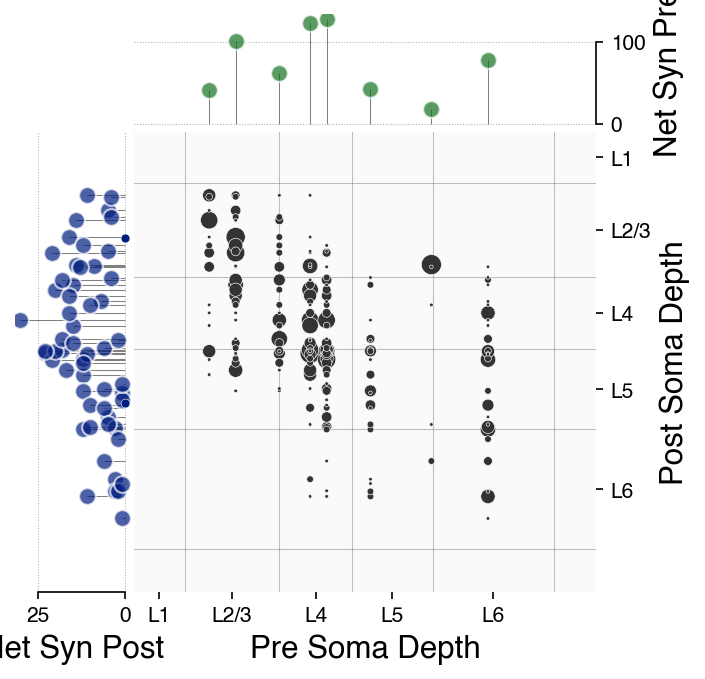

In [48]:
syn_df_alt = syn_df.copy()
syn_df_alt['cell_type_pre'] = syn_df_alt['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))
syn_df_alt['cell_type_post'] = syn_df_alt['cell_type_post'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))

change_idx = syn_df_alt.query('pre_pt_root_id in @pitc_root_ids').index
syn_df_alt.loc[change_idx, 'cell_type_pre'] = 'pITC'

change_idx = syn_df_alt.query('post_pt_root_id in @pitc_root_ids').index
syn_df_alt.loc[change_idx, 'cell_type_post'] = 'pITC'

df = make_target_df(
    "pITC",
    "PTC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["PTC"],
    pre_color=ctype_hues["ITC"],
    post_df=ct_df.query("cell_type == 'PTC'"),
    pre_df=ct_df.query("pt_root_id in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

fig.savefig(f"{plot_dir}/matrix_plot_pITC_to_PTC.pdf", bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


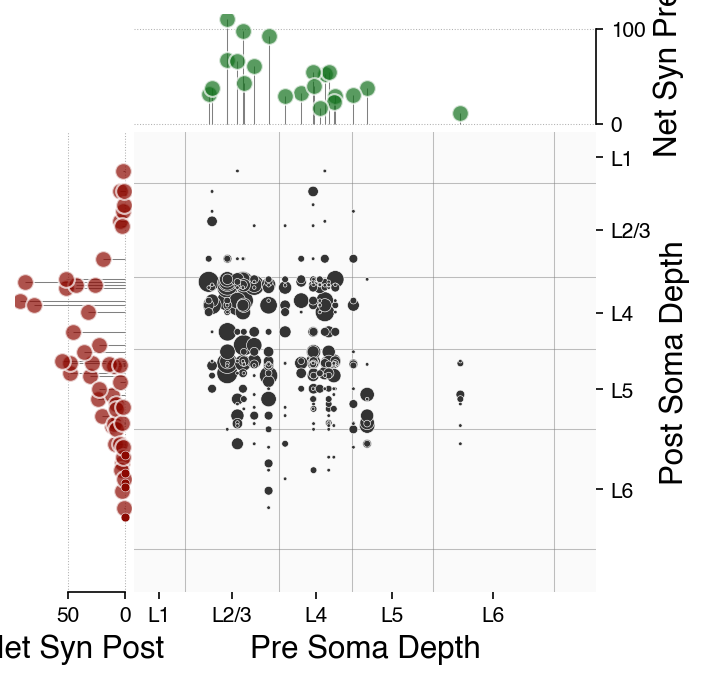

In [50]:
df = make_target_df(
    "ITC",
    "DTC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["DTC"],
    pre_color=ctype_hues["ITC"],
    post_df=ct_df.query("cell_type == 'DTC'"),
    pre_df=ct_df.query("cell_type == 'ITC' and pt_root_id not in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

fig.savefig(f"{plot_dir}/matrix_plot_dITC_to_DTC.pdf", bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


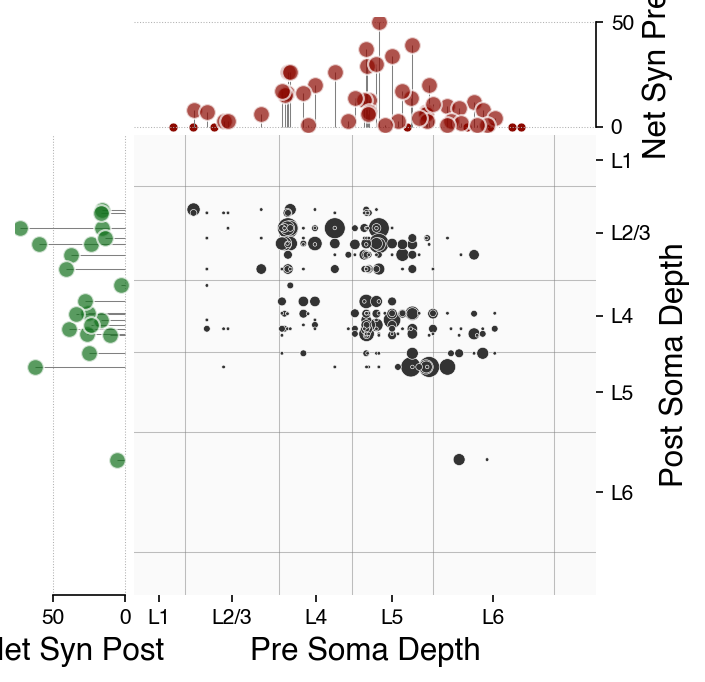

In [52]:
df = make_target_df(
    "DTC",
    "ITC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    pre_color=ctype_hues["DTC"],
    post_color=ctype_hues["ITC"],
    pre_df=ct_df.query("cell_type == 'DTC'"),
    post_df=ct_df.query("cell_type == 'ITC' and pt_root_id not in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

fig.savefig(f"{plot_dir}/matrix_plot_DTC_to_dITC.pdf", bbox_inches='tight')

In [ ]:
syn_df_alt = syn_df.copy()
syn_df_alt['cell_type_pre'] = syn_df_alt['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))
syn_df_alt['cell_type_post'] = syn_df_alt['cell_type_post'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))

change_idx = syn_df_alt.query('pre_pt_root_id in @pitc_root_ids').index
syn_df_alt.loc[change_idx, 'cell_type_pre'] = 'pITC'

change_idx = syn_df_alt.query('post_pt_root_id in @pitc_root_ids').index
syn_df_alt.loc[change_idx, 'cell_type_post'] = 'pITC'

df = make_target_df(
    "DTC",
    "pITC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["ITC"],
    pre_color=ctype_hues["DTC"],
    pre_df=ct_df.query("cell_type == 'DTC'"),
    post_df=ct_df.query("pt_root_id in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

# fig.savefig(f"{plot_dir}/matrix_plot_pITC_to_PTC.pdf", bbox_inches='tight')

In [ ]:
df_pitc = make_target_df(
    "DTC",
    "pITC",
    syn_df_alt,
)

df_ditc = make_target_df(
    "DTC",
    "ITC",
    syn_df_alt,
)

df_ditc["cat"] = "ditc"
df_pitc["cat"] = "pitc"

df_pitc_ptc = make_target_df(
    "PTC",
    "pITC",
    syn_df_alt,
)
df_pitc_ptc['cat'] = 'ptc'

In [ ]:
keep_cols = ["post_pt_root_id", "cat", "net_post"]
df_itc = pd.concat(
    [
        df_ditc[keep_cols].drop_duplicates("post_pt_root_id"),
        df_pitc[keep_cols].drop_duplicates("post_pt_root_id"),
        df_pitc_ptc[keep_cols].drop_duplicates("post_pt_root_id"),
    ],
    ignore_index=True,
)

extra_ids = pitc_root_ids[
    ~np.isin(pitc_root_ids, df_pitc_ptc["post_pt_root_id"])
].values
if len(extra_ids) > 0:
    df_itc = pd.concat(
        (
            df_itc,
            pd.DataFrame(
                {
                    "post_pt_root_id": extra_ids,
                    "cat": "ptc",
                    "net_post": 0,
                }
            ),
        ),
        ignore_index=True,
    )

In [23]:
layer_bounds

array([ 91.80615154, 261.21908419, 391.8631847 , 537.04973966,
       753.58049474])

In [ ]:
fig, ax = plt.subplots(figsize=(2, 3), dpi=150)
sns.stripplot(
    x="cat",
    y="net_post",
    data=df_itc,
    s=5,
    zorder=0,
    ax=ax,
    hue='cat',
    jitter=0.2,
    palette={'pitc': lighten_color(ctype_hues['ITC']), 'ditc': ctype_hues['ITC'], 'ptc': ctype_hues['PTC']},
    alpha=0.4,
)

sns.pointplot(
    x="cat",
    y="net_post",
    data=df_itc,
    color="k",
    estimator=np.mean,
    # zorder=20,
    ax=ax,
    join=False,
    # legend=False,
)
ax.legend().set_visible(False)

ax.set_ylabel('Net input')
ax.set_xlabel(None)
ax.set_xticklabels([r'DTC$\rightarrow$dITC', r'DTC$\rightarrow$pITC', r'PTC$\rightarrow$pITC'], rotation=90)
sns.despine(ax=ax)

fig.savefig(f'{plot_dir}/itc_input_comparison.pdf', bbox_inches='tight')

In [ ]:
stats.mannwhitneyu(
    df_itc.query('cat == "pitc"')["net_post"],
    df_itc.query('cat == "ditc"')["net_post"],
)

In [ ]:
stats.mannwhitneyu(
    df_itc.query('cat == "pitc"')["net_post"],
    df_itc.query('cat == "ptc"')["net_post"],
)

In [ ]:
df_p = make_target_df(
    "PTC",
    "PTC",
    syn_df,
)
df_p['cat'] = 'ptc'

df_d = make_target_df(
    "DTC",
    "PTC",
    syn_df,
)
df_d['cat'] = 'dtc'

In [ ]:
df_pd = pd.concat(
    (
        df_p.drop_duplicates('pre_pt_root_id'),
        df_d.drop_duplicates('pre_pt_root_id'),
    ),
    ignore_index=True,
)

In [ ]:
fig, ax = plt.subplots(figsize=(2, 3), dpi=150)
sns.stripplot(
    x="cat",
    y="net_pre",
    data=df_pd,
    s=5,
    zorder=0,
    ax=ax,
    hue='cat',
    jitter=0.2,
    palette={'ptc':ctype_hues['PTC'], 'dtc': ctype_hues['DTC']},
    alpha=0.4,
)

sns.pointplot(
    x="cat",
    y="net_post",
    data=df_pd,
    color="k",
    estimator=np.mean,
    # zorder=20,
    ax=ax,
    join=False,
    # legend=False,
)
ax.legend().set_visible(False)

ax.set_ylabel('Net input')
ax.set_xlabel(None)
ax.set_xticklabels([r'PTC$\rightarrow$PTC', r'DTC$\rightarrow$PTC'], rotation=90)
sns.despine(ax=ax)

fig.savefig(f'{plot_dir}/ptc_input_comparison.pdf', bbox_inches='tight')

In [ ]:
stats.mannwhitneyu(
    df_pd.query('cat == "ptc"')["net_pre"],
    df_pd.query('cat == "dtc"')["net_pre"],
)

In [ ]:
np.std(df_pd.query('cat == "ptc"')['net_pre'])/np.mean(df_pd.query('cat == "ptc"')['net_pre'])

In [ ]:
np.std(df_pd.query('cat == "dtc"')['net_pre'])/np.mean(df_pd.query('cat == "dtc"')['net_pre'])

In [ ]:
fig, ax = plt.subplots(figsize=(2, 3), dpi=150)
sns.histplot(
    x="net_pre",
    data=df_pd,
    zorder=0,
    ax=ax,
    hue='cat',
    cumulative=True,
    palette={'ptc':ctype_hues['PTC'], 'dtc': ctype_hues['DTC']},
    element='step',
    fill=False,
    stat='probability',
    common_norm=False,
    
)

ax.legend().set_visible(False)

ax.set_ylabel('Net input')
ax.set_xlabel(None)
# ax.set_xticklabels([r'DTC$\rightarrow$dITC', r'DTC$\rightarrow$pITC', r'PTC$\rightarrow$pITC'], rotation=90)
sns.despine(ax=ax)

# fig.savefig(f'{plot_dir}/itc_input_comparison.pdf', bbox_inches='tight')

In [ ]:
df = make_target_df(
    "DTC",
    "pITC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["ITC"],
    pre_color=ctype_hues["DTC"],
    pre_df=ct_df.query("cell_type == 'DTC'"),
    post_df=ct_df.query("pt_root_id in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

fig.savefig(f"{plot_dir}/matrix_plot_DTC_to_pITC.pdf", bbox_inches='tight')

In [ ]:
df = make_target_df(
    "PTC",
    "pITC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["ITC"],
    pre_color=ctype_hues["PTC"],
    pre_df=ct_df.query("cell_type == 'PTC'"),
    post_df=ct_df.query("pt_root_id in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

axes[1,1].set_xlim(0, height_bounds[1]-120)
axes[1,1].set_ylim(height_bounds[1]-120, 0)
axes[0,1].set_xlim(0, height_bounds[1]-120)
axes[1, 0].set_ylim(height_bounds[1]-120, 0)

fig.savefig(f"{plot_dir}/matrix_plot_PTC_to_pITC.pdf", bbox_inches='tight')

In [ ]:
ch_idx_pre = syn_df_alt.query('pre_pt_root_id in @pitc_root_ids').index
ch_idx_post = syn_df_alt.query('post_pt_root_id in @pitc_root_ids').index

In [ ]:
syn_df_alt.loc[ch_idx_pre, 'cell_type_pre'] = 'pITC'
syn_df_alt.loc[ch_idx_post, 'cell_type_post'] = 'pITC'

In [ ]:
# pitc_root_ids = syn_table_select.query('cl_label == 18').pre_pt_root_id.values

# syn_df_alt['cell_type_pre'] = syn_df_alt['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))
# syn_df_alt['cell_type_post'] = syn_df_alt['cell_type_post'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))

df = make_target_df(
    "pITC",
    "PTC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["PTC"],
    pre_color=ctype_hues["ITC"],
    post_df=ct_df.query("cell_type == 'PTC'"),
    pre_df=ct_df.query("pt_root_id in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

fig.savefig(f"{plot_dir}/matrix_plot_pITC_to_PTC.pdf", bbox_inches='tight')

In [30]:
syn_table_select.query('consensus_label == 18').pre_pt_root_id.values

(21,)

In [31]:
syn_df_alt

NameError: name 'syn_df_alt' is not defined

In [ ]:
ditc_root_ids = syn_table_select.query('cl_label == 18').pre_pt_root_id.values

syn_df_alt['cell_type_pre'] = syn_df_alt['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))
syn_df_alt['cell_type_post'] = syn_df_alt['cell_type_post'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))

df = make_target_df(
    "ITC",
    "DTC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["PTC"],
    pre_color=ctype_hues["ITC"],
    post_df=ct_df.query("cell_type == 'PTC'"),
    pre_df=ct_df.query("pt_root_id not in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

# fig.savefig(f"{plot_dir}/matrix_plot_nonpITC_to_PTC.pdf", bbox_inches='tight')

In [ ]:
# pitc_root_ids = syn_table_select.query('cl_label == 18').pre_pt_root_id.values

# syn_df_alt['cell_type_pre'] = syn_df_alt['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))
# syn_df_alt['cell_type_post'] = syn_df_alt['cell_type_post'].astype(pd.CategoricalDtype(ct_list_inh+['pITC'], ordered=True))

df = make_target_df(
    "ITC",
    "PTC",
    syn_df_alt,
)

fig, axes = matrix_plot(
    df,
    post_color=ctype_hues["PTC"],
    pre_color=ctype_hues["ITC"],
    post_df=ct_df.query("cell_type == 'PTC'"),
    pre_df=ct_df.query("pt_root_id not in @pitc_root_ids"),
    subplot_kwargs={"figsize": (5, 5), "dpi": 150},
)

# fig.savefig(f"{plot_dir}/matrix_plot_nonpITC_to_PTC.pdf", bbox_inches='tight')

In [ ]:
layer_bounds

In [ ]:
extra_oids = []
top_ids = ct_df.query('cell_type == "DTC" and soma_depth < 230 and pt_root_id not in @extra_oids').pt_root_id.values
next_ids = ct_df.query('cell_type == "DTC" and soma_depth > 230 and soma_depth < 550 and pt_root_id not in @extra_oids').pt_root_id.values

escape_df = syn_table_noitc.query('pre_pt_root_id in @top_ids')[ct_list_exc].sum().reset_index()
no_escape_df = syn_table_noitc.query('pre_pt_root_id in @next_ids')[ct_list_exc].sum().reset_index()

escape_df['targ_type'] = 'ITC-avoided'
no_escape_df['targ_type'] = 'ITC-targeted'

targ_df = pd.concat([escape_df, no_escape_df], ignore_index=True).rename(columns={'index': 'cell_type', 0: 'nsyn'})

In [ ]:
fig, ax = plt.subplots(figsize=(2,4), dpi=150)

sns.histplot(
    y='cell_type',
    hue='targ_type',
    weights='nsyn',
    stat='probability',
    multiple='dodge',
    shrink=0.8,
    data=targ_df,
    palette={'ITC-targeted': darken_color(ctype_hues['DTC']), 'ITC-avoided': lighten_color(ctype_hues['DTC'], delta=0.6)},
    edgecolor='none',
    ax=ax,
    alpha=0.8,
    legend=False,
    common_norm=False,
)
sns.despine(ax=ax,offset=3)
ax.set_xlim(0,0.6)
ax.set_xlabel('Fraction Syn.')
ax.grid(axis='x', linestyle=":", alpha=0.5, color=(0.5, 0.5, 0.5), zorder=-20)
ax.set_ylabel(None)
plt.savefig(f"{plot_dir}/itc_avoiding_dtc_targeting.pdf")

In [ ]:
np.round(df['soma_depth_post'], 0).min()

In [ ]:
dfct_e.query('hlabel == "L5-ET"').sort_values(by='soma_depth')

In [ ]:
syn_df.query('cell_type_post == "L5-ET"').sort_values(by='soma_depth_post').head()

In [ ]:
np.floor(df["soma_depth_post"]).min()

In [ ]:
hb_mod = height_bounds - [0, 120]

In [ ]:
for ct_pre in ct_list_inh:
    for ct_post in ct_list_exc:

        df = make_target_df(
            ct_pre,
            ct_post,
            syn_df,
        )

        fig, axes = matrix_plot(
            df,
            post_color=ctype_hues[ct_post],
            pre_color=ctype_hues[ct_pre],
            post_df=ct_df.query("cell_type == @ct_post"),
            pre_df=ct_df.query("cell_type == @ct_pre"),
            subplot_kwargs={"figsize": (5, 5), "dpi": 150},
        )

        axes[0, 1].set_xlim(*hb_mod)
        axes[1, 0].set_ylim(*hb_mod[::-1])
        axes[1, 1].set_xlim(*hb_mod)
        axes[1, 1].set_ylim(*hb_mod[::-1])

        # axes[0, 1].set_xlim(
        #     (np.floor(df["soma_depth_post"]).min()-40, np.ceil(df["soma_depth_post"]).max()+40)
        # )
        # axes[1, 1].set_xlim(
        #     (np.floor(df["soma_depth_post"]).min()-40, np.ceil(df["soma_depth_post"]).max()+40)
        # )
        
        fig.savefig(f"{plot_dir}/supplement_matrix_{ct_pre}_to_{ct_post}.pdf", bbox_inches='tight')

In [ ]:
i_oids = ct_df.pt_root_id.values

syn_depths = {}
for oid in i_oids:
    nrn = fc.io_utils.load_root_id(
        oid,
        project_paths,
    )
    syn_depths[oid] = tform.apply_project('y', nrn.anno.post_syn.df['ctr_pt_position'])

In [ ]:
for ct_post in ct_list_exc:

    weighted_dist = syn_df.query('cell_type_post == @ct_post').groupby('pre_pt_root_id').count()['id']
    weighted_dist = weighted_dist/weighted_dist.sum()

    syn_locs = []
    weights = []
    ct_class = []
    for oid, wt in weighted_dist.items():
        syn_locs.append(syn_depths[oid])
        weights.append(np.full(len(syn_depths[oid]), wt / len(syn_depths[oid])))
        ct_class.append(np.full(len(syn_depths[oid]),ct_df.set_index('pt_root_id').loc[oid].cell_type)) 
    syn_locs = np.concatenate(syn_locs)
    weights = np.concatenate(weights)
    ct_class = np.concatenate(ct_class)

    hdf = pd.DataFrame(
        {
            'syn_locs': syn_locs,
            'weights': weights,
            'ct_class': ct_class,
        }
    )

    fig, ax = plt.subplots(figsize=(3, 5), dpi=150)

    sns.kdeplot(
        y="syn_locs",
        weights="weights",
        # hue='ct_class',
        data=hdf,
        # palette=ctype_hues,
        color=ctype_hues[ct_post],
        bw_adjust=0.8,
        ax=ax,
    )

    plotting_code.plot_layers(
        layer_bounds,
        depth_bounds=height_bounds,
        span=ax.get_xlim(),
        ax=ax,
        linestyle="--",
        color=(0.5, 0.5, 0.5),
        alpha=0.5,
        linewidth=1,
    )

    sns.despine(ax=ax, offset=3)
    plt.tight_layout()
    fig.savefig(f"{plot_dir}/supp_input_image_{ct_post}.pdf")
    plt.close(fig)

### Use classifications to generate same list

In [ ]:
now = datetime.datetime.utcnow()

In [ ]:
extended_ct_df = client.materialize.live_live_query('aibs_metamodel_mtypes_v661_v2', timestamp=now)

In [ ]:
nuc_df = client.materialize.query_table('nucleus_detection_v0', timestamp=now)

In [ ]:
extended_ct_df = extended_ct_df.drop(columns='id').merge(
    nuc_df[['id', 'pt_root_id']],
    left_on='target_id',
    right_on='id',
).drop(columns=['created', 'valid', 'target_id'])

In [ ]:
syn_table

In [ ]:
ct_list = list(ct_list_exc[:-1]) + list(ct_list_inh)

In [ ]:
def get_pre_df(root_id):
    fname = f"{project_paths.skeletons}/skeleton_files/{root_id}.h5"
    nrn = meshwork.load_meshwork(fname)
    return nrn.anno.pre_syn.df.drop(columns=["post_pt_root_id", "pre_pt_level2_id"])

def get_extended_ct_syn(root_id, extended_ct_df, timestamp, ct_list):
    sdf = get_pre_df(root_id)
    sdf['post_pt_root_id'] = client.chunkedgraph.get_roots(sdf['post_pt_supervoxel_id'], timestamp=timestamp)
    
    sdf_ct = sdf.merge(
        extended_ct_df[['pt_root_id', 'cell_type']],
        left_on='post_pt_root_id',
        right_on='pt_root_id',
    )
    sdf_ct['cell_type']=sdf_ct['cell_type'].astype(pd.CategoricalDtype(ct_list, ordered=True))
    return sdf_ct.pivot_table(
        index='pre_pt_root_id',
        columns='cell_type',
        values='size',
        aggfunc='count',
    )[ct_list]

In [ ]:
syn_ct_dfs = []
for root_id in tqdm.tqdm(i_oids):
    sdf = get_extended_ct_syn(
            root_id,
            extended_ct_df,
            now,
            ct_list,
        )
    syn_ct_dfs.append(sdf)
        

In [ ]:
ct_df

In [ ]:
syn_table_ext = pd.concat(syn_ct_dfs).merge(
    ct_df,
    left_index=True,
    right_on='pt_root_id',
)

In [ ]:
ct_list_exc_ext = ct_list_exc[:-1]

In [ ]:
syn_table_noitc = syn_table_ext.query("cell_type!='ITC'").copy().merge(
    syn_table_select[['pt_root_id', 'consensus_label']],
    on='pt_root_id',
)

syn_table_noitc['net_syn'] = syn_table_noitc[ct_list_exc_ext].sum(axis=1)

syn_table_noitc_norm = syn_table_noitc.copy()
syn_table_noitc_norm[ct_list_exc_ext] = np.divide(
    syn_table_noitc_norm[ct_list_exc_ext].values,
    np.atleast_2d(syn_table_noitc_norm[ct_list_exc_ext].values.sum(axis=1)).T,
)



In [ ]:
syn_table_noitc_norm

In [ ]:
yvals = np.cumsum(
    syn_table_noitc.groupby("consensus_label").count()["cell_type"]
).values

fig, axes = plt.subplots(
    figsize=(7.4, 2.5),
    nrows=2,
    ncols=2,
    gridspec_kw={
        "height_ratios": [1, 5],
        "hspace": 0.025,
        "width_ratios": [12,1],
        "wspace": 0.025,
    },
    dpi=300,
)

ax = axes[0,0]
ax.set_visible(True)
ax.bar(
    x=np.arange(len(syn_table_noitc)) + 0.5,
    height=syn_table_noitc.sort_values(by=["consensus_label", "soma_depth"])[
        "net_syn"
    ],
    color=[
        ctype_hues[x]
        for x in syn_table_noitc.sort_values(by=["consensus_label", "soma_depth"])[
            "cell_type"
        ]
    ],
    alpha=1,
    width=0.8,
)

ax.set_ylim(2, 10_500)
ax.yaxis.set_ticks_position("left")
ax.set_yticks([10, 100, 1000])
sns.despine(ax=ax, offset=3)
_ = ax.set_yticklabels(["10$^1$", "10$^2$", "10$^3$"], fontdict={"fontsize": 5})
ax.set_yscale("log")
ax.hlines(
    [10, 100, 1000, 10_000],
    0,
    len(syn_table_noitc),
    linewidth=0.5,
    color=(0.5, 0.5, 0.5),
    alpha=0.5,
    zorder=-10,
)
ax.tick_params(length=2, width=0.25, axis="y")
ax.tick_params(length=0, width=0, axis="x")
# ax.invert_yaxis()
ax.set_xticks([])
ax.set_xlabel(None)

ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_linewidth(0.25)
ax.spines["top"].set_linewidth(0.25)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(rotation=0)

ax = axes[1,0]
ax.sharex(axes[0,0])
sns.heatmap(
    syn_table_noitc_norm.sort_values(by=["consensus_label", "soma_depth"])[
        ct_list_exc_ext
    ].T,
    # square=True,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=0.4,
    ax=ax,
    cbar=False,
)
ax.vlines(yvals, 0, len(ct_list_exc_ext), color="w", linewidth=1)
ax.hlines(
    [3, 5, 8, 12, 14, 17, len(ct_list_exc_ext)],
    0,
    len(syn_table),
    color="w",
    linewidth=1,
    alpha=0.75,
)

_ = ax.set_xticks([])

ax.set_xticks(np.concatenate(([0], yvals[0:-1])) + 0.6)
ax.set_xticklabels(
    np.arange(len(syn_table_noitc["consensus_label"].unique())),
    fontdict={"fontsize": 5, 'rotation': 0},
)

ax.tick_params(length=2, width=0.5, axis="y")
ax.tick_params(length=0, width=0, axis="x")

ax.set_yticks(np.arange(len(ct_list_exc_ext)) + 0.5)
ax.set_yticklabels(ct_list_exc_ext, rotation=0, fontdict={"size": 4})
ax.set_xlabel("")

blank_ax = axes[0,1]
blank_ax.set_visible(False)

ax = axes[1,1]
sns.histplot(
    y='hlabel',
    data=dfct_e,
    edgecolor='w',
    hue='hlabel',
    palette=ctype_hues,
    alpha=1,
    legend=False,
    ax=ax,
    shrink=0.8,
)
ax.set_ylim(np.array(axes[1,0].get_ylim())-0.5)
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xticks([0,50,100,150])
ax.vlines(
    [50, 100, 150],
    0,
    syn_table_noitc.shape[0],
    linewidth=0.5,
    color=(0.5, 0.5, 0.5),
    alpha=0.5,
    zorder=-10,
)
sns.despine(ax=ax, offset=3, left=True, right=True, top=True, bottom=False, trim=True)
ax.set_xlabel('Num. Cell', fontdict={'size': 5})
ax.xaxis.set_tick_params(length=2)
ax.set_xticklabels([0,50,100,150], fontdict={'size': 5})

# fig.savefig(
#     f"{plot_dir}/target_distribitions_no_itc_horiz_bars.pdf", bbox_inches="tight"
# )

In [ ]:
syn_table_noitc.query('consensus_label==6').sort_values(by='soma_depth')

In [ ]:
ct_list

autapses

In [ ]:
import pcg_skel
from meshparty import meshwork
from caveclient import CAVEclient

client = CAVEclient('minnie65_phase3_v1')

In [ ]:
timestamp = client.materialize.get_timestamp(version=version)

In [ ]:
soma_df = client.materialize.query_table(project_info.slant_table, filter_in_dict={'pt_root_id': ct_df['pt_root_id']}, timestamp=timestamp).drop_duplicates('pt_root_id')

In [ ]:
ct_s_df = ct_df.merge(
    soma_df[['pt_root_id', 'pt_position']],
    on='pt_root_id',
)

In [ ]:
autapse_df = []
for _, row in tqdm.tqdm(ct_s_df.iterrows()):
    root_id = row["pt_root_id"]
    pos = row["pt_position"]

    nrn = pcg_skel.coord_space_meshwork(
        root_id=root_id,
        client=client,
        root_point=pos,
        root_point_resolution=[4, 4, 40],
        collapse_soma=True,
        synapses="all",
        synapse_table=client.info.get_datastack_info().get("synapse_table"),
        timestamp=timestamp,
        remove_self_synapse=False,
    )

    is_axon = meshwork.algorithms.split_axon_by_annotation(
        nrn,
        "pre_syn",
        post_anno="post_syn",
        return_quality=False,
    )

    nrn.anno.add_annotations("is_axon", is_axon, mask=True)

    auto_pre_df = nrn.anno.pre_syn.df.query("pre_pt_root_id == post_pt_root_id")
    auto_post_df = nrn.anno.post_syn.df.query("pre_pt_root_id == post_pt_root_id")

    check_df = auto_pre_df[
        ["id", "ctr_pt_position", "pre_pt_level2_id", "pre_pt_mesh_ind"]
    ].merge(
        auto_post_df[["id", "post_pt_level2_id", "post_pt_mesh_ind"]],
        on="id",
    )

    ds = []
    for x, y in zip(check_df["pre_pt_mesh_ind"], check_df["post_pt_mesh_ind"]):
        ds.append(nrn.distance_between(x, y) / 1000)
    ds = np.array(ds).squeeze()

    check_df['root_id'] = root_id
    check_df["path_dist"] = ds
    autapse_df.append(check_df.query("path_dist > 50"))

In [ ]:
autapse_df = pd.concat(autapse_df, ignore_index=True)

In [ ]:
autapse_df.to_feather(f'{data_dir}/autapse_df.feather')

In [ ]:
autapse_df.groupby('root_id').count().sort_values(by='id').tail(20)

In [ ]:
autapse_df = autapse_df.merge(
    ct_df,
    left_on='root_id',
    right_on='pt_root_id',
    how='left',
).drop(columns='pt_root_id')

In [ ]:
autapse_df.groupby('cell_type').count()

In [ ]:
autapse_df.query('cell_type == "ITC"').sort_values(by='root_id')

In [ ]:
autapse_df.groupby('root_id').agg(num_autapse = pd.NamedAgg('id', 'count'))

In [ ]:
st_auto = syn_table_select.merge(
    autapse_df.groupby('root_id').agg(num_autapse = pd.NamedAgg('id', 'count')),
    left_on='pre_pt_root_id',
    right_index=True,
    how='left',
)

st_auto['num_autapse'] = st_auto['num_autapse'].fillna(0).astype(int)

In [ ]:
st_auto.columns

In [25]:
dfct_e.groupby('hlabel').count()

,root_id,soma_depth,tip_len_dist_dendrite_p50,tip_tort_dendrite_p50,num_syn_dendrite,num_syn_soma,path_length_dendrite,radial_extent_dendrite,syn_dist_distribution_dendrite_p50,syn_size_distribution_soma_p50,...,ego_count_pca1,ego_count_pca2,ego_count_pca3,ego_count_pca4,pt_root_id,classification_system,cell_type,umap0_raw,umap1_raw,hlabel_int
hlabel,,,,,,,,,,,,,,,,,,,,,
L2a,57,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
L2b,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
L2c,73,73,73,73,73,73,73,73,73,73,...,73,73,73,73,73,73,73,73,73,73
L3a,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
L3b,97,97,97,97,97,97,97,97,97,97,...,97,97,97,97,97,97,97,97,97,97
L4a,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
L4b,152,152,152,152,152,152,152,152,152,152,...,152,152,152,152,152,152,152,152,152,152
L4c,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
L5a,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30


In [ ]:
sns.swarmplot(
    x='cell_type_pre',
    y='num_autapse',
    data=st_auto,
    hue='cell_type_pre',
    palette=ctype_hues,
    size=5,
)

In [ ]:
st_auto.sort_values(by='num_autapse', ascending=False).head(20)[['pre_pt_root_id', 'cell_type_pre', 'num_autapse']].set_index('pre_pt_root_id').to_clipboard()

In [ ]:
st_auto.groupby('consensus_label').num_autapse.sum()

In [ ]:
inhib_prop_df = pd.read_feather(f"{data_dir}/inhib_prop_df.feather")

In [ ]:
inhib_prop_df = inhib_prop_df.merge(st_auto[['pre_pt_root_id', 'num_autapse']].rename(columns={'pre_pt_root_id': 'root_id'}), on='root_id', how='left')

In [ ]:
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
sns.scatterplot(
    x='num_autapse',
    y='num_out',
    data=inhib_prop_df.query('pred_ct == "PTC"'),
    s=10,
)

In [ ]:
num_out = []
for root_id in inhib_prop_df['root_id']:
    nrn = fc.io_utils.load_root_id(root_id, project_paths)
    num_out.append(len(nrn.anno.pre_syn.df))

In [ ]:
inhib_prop_df['num_out'] = num_out

In [ ]:
syn_table_et = syn_table_select.query('consensus_label < 16').reset_index(drop=True).copy()

In [ ]:
norm_array = syn_table_et[ct_list_exc].values / np.atleast_2d(syn_table_et[ct_list_exc].values.sum(axis=1)).T

In [ ]:
syn_table_select.consensus_label.max()

In [ ]:
syn_table_select[ct_list_norm]

In [ ]:
client.materialize.version = 495

In [ ]:
manual_multi_df = client.materialize.query_table('pt_synapse_targets').drop_duplicates('post_pt_root_id', keep=False)
manual_multi_df

In [ ]:
from sklearn import decomposition

model = decomposition.NMF(n_components=8, init='random', random_state=0)

In [ ]:
from caveclient import CAVEclient
client = CAVEclient('minnie65_phase3_v1')

In [ ]:
pf_df = client.materialize.query_table('proofreading_status_public_release')

In [ ]:
pf_df.query('status_axon == "extended"')

In [ ]:
from nglui import statebuilder

In [ ]:
statebuilder.helpers.make_point_statebuilder(client).render_state(pf_df, return_as='html')

In [ ]:
dfct_e

In [ ]:
from caveclient import CAVEclient
client = CAVEclient('minnie65_phase3_v1')

In [ ]:
table_name = 'allen_column_mtypes_v2'
schema_name = "cell_type_reference"
description = "Cluster-based M-types for the minnie column corresponding the updated clustering used for the revision of Schneider-Mizell et al. 2023. Maintained and created by Casey Schneider-Mizell"

In [ ]:
client.annotation.get_table_metadata('allen_column_mtypes_v1')

In [ ]:
client.annotation.create_table(
    table_name,
    schema_name,
    description,
    [4,4,40],
    reference_table='nucleus_detection_v0',
    track_target_id_updates=True,
)

In [ ]:
stage = client.annotation.stage_annotations(table_name)

In [ ]:
ict_df = ct_df.copy()

ict_df['classification_system'] = 'inhibitory'

now = client.materialize.get_timestamp(version=version)
soma_df = client.materialize.tables.nucleus_neuron_svm(pt_root_id=ict_df['pt_root_id'], cell_type='neuron').query(timestamp=now)

ict_df = ict_df.merge(
    soma_df[['pt_root_id', 'id']],
    on='pt_root_id',
    validate='1:1',
)

In [ ]:
version

In [ ]:
now

In [ ]:
import datetime
client.materialize.tables.nucleus_neuron_svm(pt_root_id=864691135848928350).query(timestamp=datetime.datetime.utcnow())

In [ ]:
client.chunkedgraph.suggest_latest_roots(864691136674080135)

In [ ]:
e_oids = dfct_e['pt_root_id'].values

In [ ]:
e_oids = e_oids[e_oids!=864691136674080135]

In [ ]:
e_oids

In [ ]:
ect_df = dfct_e.copy()[['pt_root_id', 'hlabel']]

ect_df['classification_system'] = 'excitatory'

now = client.materialize.get_timestamp(version=version)
soma_df = client.materialize.tables.nucleus_neuron_svm(pt_root_id=e_oids, cell_type='neuron').live_query(timestamp=now, allow_missing_lookups=True)



soma_df.loc[1187, 'id'] = 256561
soma_df.loc[1187, 'pt_root_id'] = 864691136674080135

ect_df = ect_df.merge(
    soma_df[['pt_root_id', 'id']],
    on='pt_root_id',
    validate='1:1',
)

In [ ]:
ect_df.query('pt_root_id == 864691136674080135')

In [ ]:
ect_df['id'] = ect_df['id'].astype(int)

In [ ]:
stage = client.annotation.stage_annotations(table_name)

In [ ]:
for _, row in ect_df.iterrows():
    stage.add(
        target_id=row['id'],
        cell_type=row['hlabel'],
        classification_system=row['classification_system'],
    )

In [ ]:
for _, row in ict_df.iterrows():
    stage.add(
        target_id=row['id'],
        cell_type=row['cell_type'],
        classification_system=row['classification_system'],
    )

In [ ]:
client.annotation.upload_staged_annotations(stage)

In [ ]:
client.annotation.get_annotation(table_name, 1188+100)

In [ ]:
client.annotation.get_annotation_count(table_name)

In [ ]:
ect_df.loc[91, 'id'] = 258355
ect_df.loc[98, 'id'] = 256602
ect_df.loc[628, 'id'] = 260817

In [ ]:
client.materialize.tables.nucleus_detection_v0(pt_root_id=ect_df.query('id<100')['pt_root_id']).query(timestamp=now)

In [ ]:
client.materialize.live_live_query(table_name, timestamp='now', metadata=False)

In [ ]:
ict_df.groupby('cell_type').count()

---

In [73]:
inh_ptc_oids = syn_table_select.query('consensus_label==20').pre_pt_root_id.values
inh_dtc_oids = syn_table_select.query('consensus_label==19').pre_pt_root_id.values

In [74]:
inh_ptc_syns_all = syn_df.query('pre_pt_root_id in @inh_ptc_oids')
inh_dtc_syns_all = syn_df.query('pre_pt_root_id in @inh_dtc_oids')

In [75]:
inh_ptc_syns_all['cell_type_post'] = inh_ptc_syns_all['cell_type_post'].apply(lambda x: 'Exc' if x in ct_list_exc else x)
inh_ptc_syns_all['cell_type_post'] = inh_ptc_syns_all['cell_type_post'].astype(
    pd.CategoricalDtype(['PTC', 'DTC', 'STC', 'ITC'], ordered=True)
)
inh_dtc_syns_all['cell_type_post'] = inh_dtc_syns_all['cell_type_post'].apply(lambda x: 'Exc' if x in ct_list_exc else x)
inh_dtc_syns_all['cell_type_post'] = inh_dtc_syns_all['cell_type_post'].astype(
    pd.CategoricalDtype(['PTC', 'DTC', 'STC', 'ITC'], ordered=True)
)


/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_56097/3085155336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inh_ptc_syns_all['cell_type_post'] = inh_ptc_syns_all['cell_type_post'].apply(lambda x: 'Exc' if x in ct_list_exc else x)
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_56097/3085155336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inh_ptc_syns_all['cell_type_post'] = inh_ptc_syns_all['cell_type_post'].astype(
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipyke

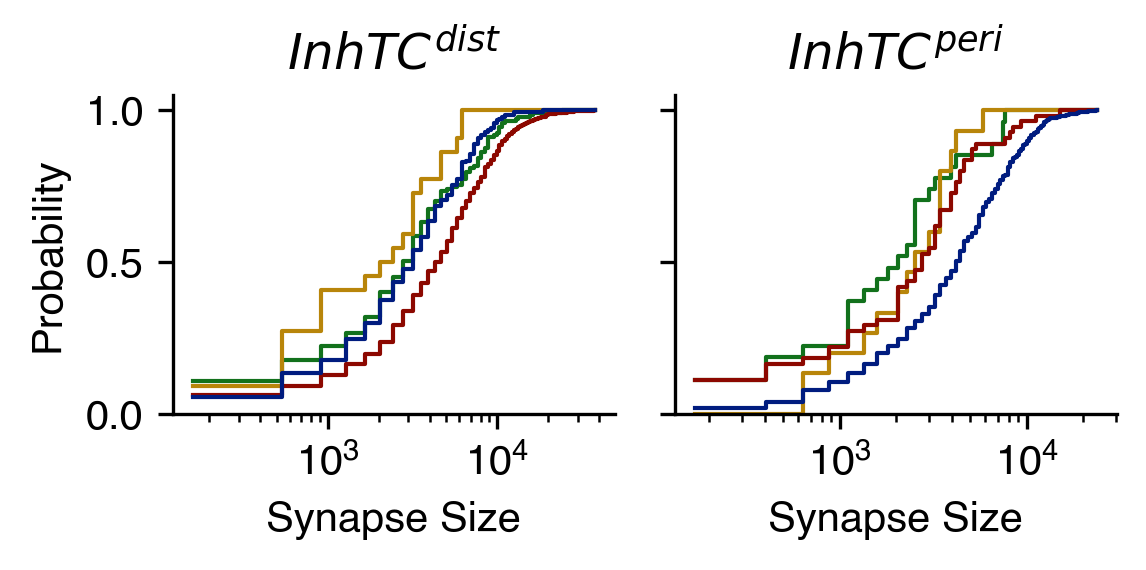

In [76]:
fig, axes = plt.subplots(figsize=(4,2), ncols=2, sharey=True, dpi=300)

ax = axes[0]
sns.histplot(
    x='size',
    hue='cell_type_post',
    palette=ctype_hues,
    data=inh_dtc_syns_all.query('cell_type_post != "Exc"'),
    cumulative=True,
    ax=ax,
    legend=False,
    stat='probability',
    common_norm=False,
    element='step',
    fill=False,
    linewidth=1,
    bins=100,
)
ax.set_xscale('log')
ax.set_title('$InhTC^{dist}$')
ax.set_xlabel('Synapse Size')
sns.despine(ax=ax)

ax = axes[1]
sns.histplot(
    x='size',
    hue='cell_type_post',
    palette=ctype_hues,
    data=inh_ptc_syns_all.query('cell_type_post != "Exc"'),
    cumulative=True,
    ax=ax,
    legend=False,
    stat='probability',
    common_norm=False,
    element='step',
    fill=False,
    linewidth=1,
    bins=100,
)
ax.set_xscale('log')
ax.set_title('$InhTC^{peri}$')
ax.set_xlabel('Synapse Size')
sns.despine(ax=ax)
fig.tight_layout()
# fig.savefig(f'{plot_dir}/inhtc_targeting_synapse_size_distribution.pdf', bbox_inches='tight')

In [85]:
inh_ptc_syns_all.query('cell_type_post != "Exc"')[['cell_type_post', 'size']].dropna().to_clipboard()

In [80]:
inh_dtc_syns_all.query('cell_type_post != "Exc"')[['cell_type_post', 'size']].to_clipboard()

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_56097/3218083647.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_56097/3218083647.py:23: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


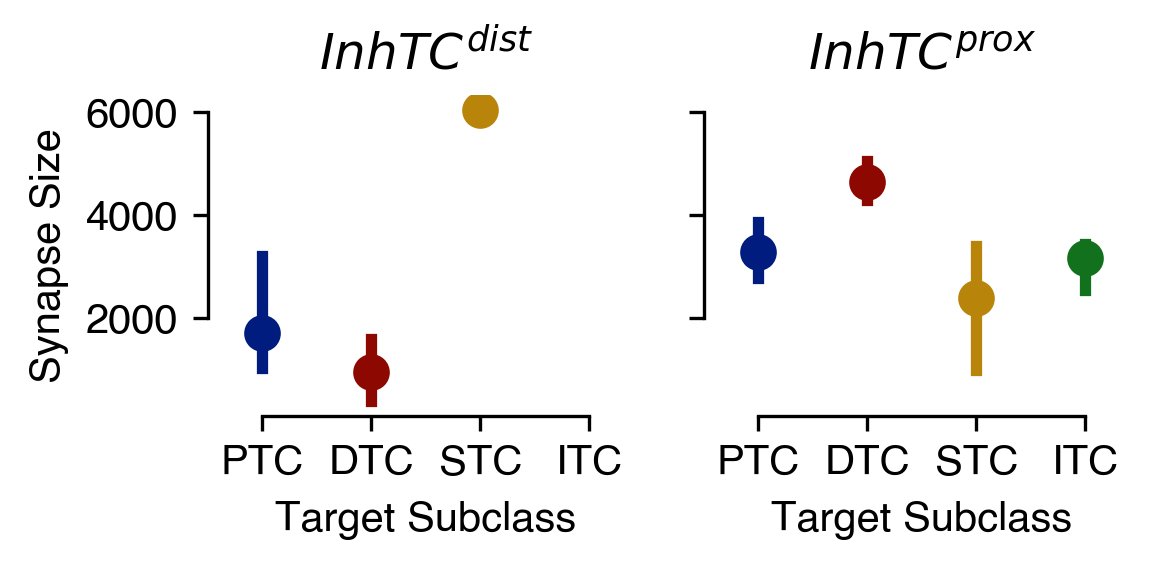

In [62]:
fig, axes = plt.subplots(figsize=(4,2), ncols=2, sharey=True, dpi=300)

ax = axes[0]
sns.pointplot(
    x='cell_type_post',
    y='size',
    hue='cell_type_post',
    estimator='median',
    errorbar='ci',
    palette=ctype_hues,
    data=inh_dtc_syns_all.query('cell_type_post != "Exc"'),
    join=False,
    ax=ax,
)

ax.legend().set_visible(False)
ax.set_title('$InhTC^{dist}$')
ax.set_xlabel('Target Subclass')
ax.set_ylabel('Synapse Size')
sns.despine(ax=ax, trim=True)

ax = axes[1]
sns.pointplot(
    x='cell_type_post',
    y='size',
    hue='cell_type_post',
    estimator='median',
    errorbar='ci',
    palette=ctype_hues,
    data=inh_ptc_syns_all.query('cell_type_post != "Exc"'),
    join=False,
    ax=ax,
)
ax.legend().set_visible(False)
ax.set_xlabel('Target Subclass')
ax.set_title('$InhTC^{prox}$')
ax.set_ylabel('')
sns.despine(ax=ax, trim=True)
fig.tight_layout()
# fig.savefig(f'{plot_dir}/inhtc_targeting_synapse_size.pdf', bbox_inches='tight')

In [86]:
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols


In [188]:
formula = 'size ~ C(cell_type_post)'
lm = ols(formula, inh_dtc_syns_all.query('cell_type_post != "Exc"')).fit()

In [189]:
t2 = anova_lm(lm)

In [107]:
inh_dtc_syns_all.query('cell_type_post != "Exc"')['size'].astype(float)

59879     2692.0
59880    10084.0
59881    13348.0
59882     6484.0
59883     5804.0
          ...   
79465     2996.0
79466     1232.0
79467     1300.0
79468     1056.0
79469      780.0
Name: size, Length: 1664, dtype: float64

In [112]:
np.array(inh_dtc_syns_all.query('cell_type_post == cell_type_post')['cell_type_post'].values)

array(['DTC', 'DTC', 'DTC', ..., 'PTC', 'ITC', 'PTC'], dtype=object)

In [183]:
sm.stats.ttest_ind(

Signature:
sm.stats.ttest_ind(
    x1,
    x2,
    alternative='two-sided',
    usevar='pooled',
    weights=(None, None),
    value=0,
)
Docstring:
ttest independent sample

Convenience function that uses the classes and throws away the intermediate
results,
compared to scipy stats: drops axis option, adds alternative, usevar, and
weights option.

Parameters
----------
x1 : array_like, 1-D or 2-D
    first of the two independent samples, see notes for 2-D case
x2 : array_like, 1-D or 2-D
    second of the two independent samples, see notes for 2-D case
alternative : str
    The alternative hypothesis, H1, has to be one of the following

       * 'two-sided' (default): H1: difference in means not equal to value
       * 'larger' :   H1: difference in means larger than value
       * 'smaller' :  H1: difference in means smaller than value

usevar : str, 'pooled' or 'unequal'
    If ``pooled``, then the standard deviation of the samples is assumed to be
    the same. If ``unequal``, then

In [280]:
inh_dtc_syns_all.query('cell_type_post == "DTC"')['size'].median()

4652.0

In [282]:
inh_dtc_syns_all.query('cell_type_post != "DTC" and cell_type_post==cell_type_post')['size'].median()

3228.0

In [283]:
4652/3228

1.4411400247831474

In [284]:
inh_ptc_syns_all.query('cell_type_post == "PTC"')['size'].median()

4390.0

In [285]:
inh_ptc_syns_all.query('cell_type_post != "PTC" and cell_type_post==cell_type_post')['size'].median()

2600.0

In [286]:
4390/2600

1.6884615384615385

In [288]:
stats.ks_2samp(
    inh_dtc_syns_all.query('cell_type_post == "DTC"')['dist_to_root'],
    inh_ptc_syns_all.query('cell_type_post == "PTC"')['dist_to_root'],
)

KstestResult(statistic=0.051975176831709595, pvalue=0.25428308422305945, statistic_location=46.29154652404785, statistic_sign=-1)

In [291]:
inh_dtc_syns_all.query('cell_type_post == "DTC"')['dist_to_root'].median(), inh_ptc_syns_all.query('cell_type_post == "PTC"')['dist_to_root'].median()

(83.52166438293457, 86.23168002319335)

In [191]:
inh_dtc_syns_all.query('cell_type_post == "ITC"')['size']

59989    4496
59990    3128
59997    2152
59999    4280
60001    1420
         ... 
78664    8196
78678    2020
78685    4120
78687    2284
79468    1056
Name: size, Length: 147, dtype: int64

In [201]:
pcts_d = {}
for ct in ['PTC', 'STC', 'ITC']:
    pcts_d[ct] = stats.ttest_ind(
        inh_dtc_syns_all.query('cell_type_post == "DTC"')['size'],
        inh_dtc_syns_all.query('cell_type_post == @ct')['size'],
    ).pvalue
    

pcts_d

{'PTC': 1.3317539103056184e-06,
 'STC': 0.002589726842626707,
 'ITC': 0.0001544714482152564}

In [279]:
pd.DataFrame(
    [pcts_d, pcts_p],
    index=['InhTC_Dist', 'InhTC_Peri'],
).to_csv(f'{plot_dir}/associated_data/inhtc_syn_size_pvals.csv')

In [204]:
sm.stats.multipletests([v for v in pcts_d.values()])

(array([ True,  True,  True]),
 array([3.99525641e-06, 2.58972684e-03, 3.08919035e-04]),
 0.016952427508441503,
 0.016666666666666666)

In [202]:
pcts_p = {}
for ct in ['DTC', 'STC', 'ITC']:
    pcts_p[ct] = stats.ttest_ind(
        inh_ptc_syns_all.query('cell_type_post == "PTC"')['size'],
        inh_ptc_syns_all.query('cell_type_post == @ct')['size'],
    ).pvalue
pcts_p

{'DTC': 0.0006294790478438044,
 'STC': 0.01307390537184277,
 'ITC': 0.0007861025556056334}

In [205]:
sm.stats.multipletests([v for v in pcts_p.values()])

(array([ True,  True,  True]),
 array([0.00188725, 0.01307391, 0.00188725]),
 0.016952427508441503,
 0.016666666666666666)

In [182]:
inh_dtc_syns_all.query('cell_type_post == "ITC"')['size'],

(59989    4496
 59990    3128
 59997    2152
 59999    4280
 60001    1420
          ... 
 78664    8196
 78678    2020
 78685    4120
 78687    2284
 79468    1056
 Name: size, Length: 147, dtype: int64,)

<Axes: xlabel='dist_to_root', ylabel='Count'>

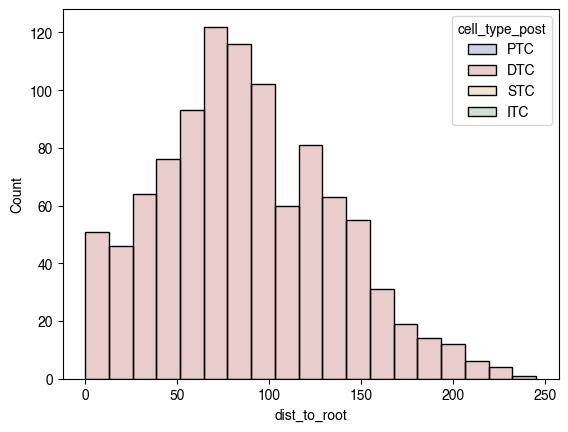

In [87]:
sns.histplot(
    x='dist_to_root',
    hue='cell_type_post',
    palette=ctype_hues,
    data=inh_dtc_syns_all.query('cell_type_post=="DTC"'),
    alpha=0.2,
)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


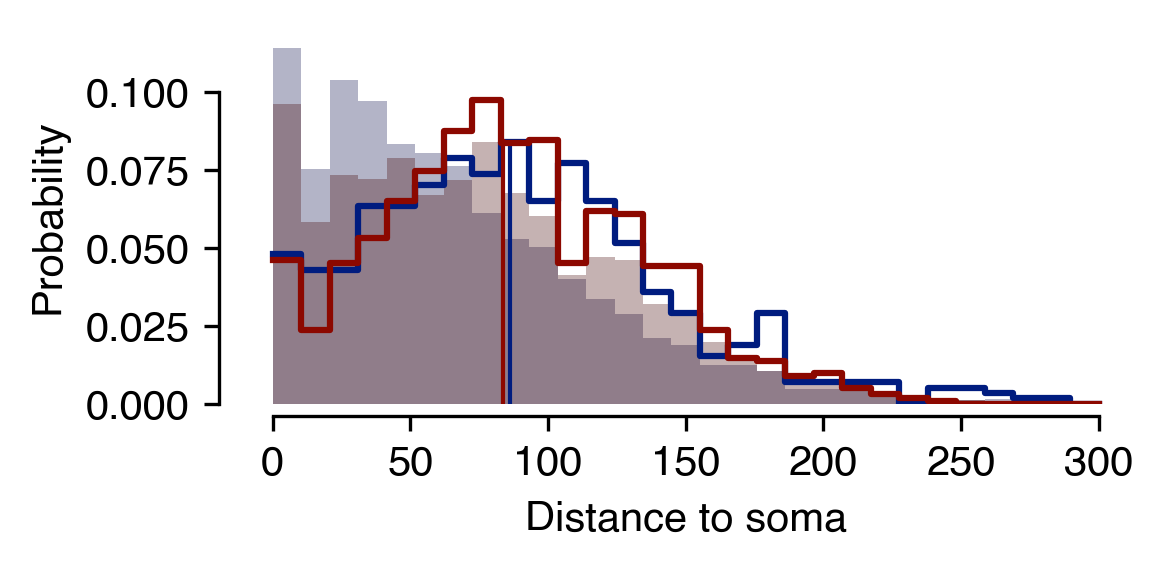

In [270]:
bins = np.linspace(0,300,30)
fig, ax = plt.subplots(figsize=(4,2), dpi=300)

sns.histplot(
    x='dist_to_root',
    color=(6/255,9/255,72/255),
    data=syn_df.query('cell_type_post=="PTC"'),
    stat='probability',
    ax=ax,
    legend=False,
    element='step',
    fill=True,
    alpha=0.3,
    linewidth=0,
    bins=bins,
)

sns.histplot(
    x='dist_to_root',
    color=(64/255,0,0),
    data=syn_df.query('cell_type_post=="DTC"'),
    stat='probability',
    ax=ax,
    legend=False,
    element='step',
    fill=True,
    alpha=0.3,
    linewidth=0,
    bins=bins,
)


sns.histplot(
    x='dist_to_root',
    hue='cell_type_post',
    palette=ctype_hues,
    data=inh_ptc_syns_all.query('cell_type_post=="PTC"'),
    element='step',
    fill=False,
    stat='probability',
    ax=ax,
    legend=False,
    bins=bins,
)
ax.vlines(inh_ptc_syns_all.query('cell_type_post=="PTC"')['dist_to_root'].median(), 0, 0.085, color=ctype_hues['PTC'], linewidth=1)

sns.histplot(
    x='dist_to_root',
    hue='cell_type_post',
    palette=ctype_hues,
    data=inh_dtc_syns_all.query('cell_type_post=="DTC"'),
    element='step',
    fill=False,
    stat='probability',
    ax=ax,
    legend=False,
    bins=bins,
)

ax.vlines(inh_dtc_syns_all.query('cell_type_post=="DTC"')['dist_to_root'].median(), 0, 0.085, color=ctype_hues['DTC'], linewidth=1)
ax.set_xlabel('Distance to soma')
sns.despine(ax=ax, trim=True, offset=3)
fig.tight_layout()
fig.savefig(f'{plot_dir}/inhtc_targeting_distance_to_root.pdf', bbox_inches='tight')

In [88]:
bins = np.arange(1,35)

x_ptc_ptc, y = np.histogram(
    inh_ptc_syns_all.query('cell_type_post=="PTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
    bins=bins
)

x_ptc_other, y = np.histogram(
    inh_ptc_syns_all.query('cell_type_post!="PTC" and cell_type_post==cell_type_post').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
    bins=bins
)

x_dtc_dtc, y = np.histogram(
    inh_dtc_syns_all.query('cell_type_post=="DTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
    bins=bins
)

x_dtc_other, y = np.histogram(
    inh_dtc_syns_all.query('cell_type_post!="DTC" and cell_type_post==cell_type_post').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
    bins=bins
)

In [359]:
inh_ptc_syns_all.query('cell_type_post=="PTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'].mean()

3.089005235602094

In [360]:
inh_ptc_syns_all.query('cell_type_post!="PTC" and cell_type_post==cell_type_post').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'].mean()

1.515625

In [346]:
stats.ttest_ind(
    inh_ptc_syns_all.query('cell_type_post=="PTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
    inh_ptc_syns_all.query('cell_type_post!="PTC" and cell_type_post==cell_type_post').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
)

Ttest_indResult(statistic=4.486659206177538, pvalue=1.0988574824085455e-05)

In [361]:
    inh_dtc_syns_all.query('cell_type_post=="DTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'].mean()

3.5774647887323945

In [362]:
    inh_dtc_syns_all.query('cell_type_post!="DTC" and cell_type_post==cell_type_post').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'].mean()

1.6330275229357798

In [365]:
stats.ttest_ind(
    inh_dtc_syns_all.query('cell_type_post=="DTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
    inh_dtc_syns_all.query('cell_type_post!="DTC" and cell_type_post==cell_type_post').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'],
)

Ttest_indResult(statistic=6.546625868562895, pvalue=1.461758108514743e-10)

In [102]:
y[0:-1]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

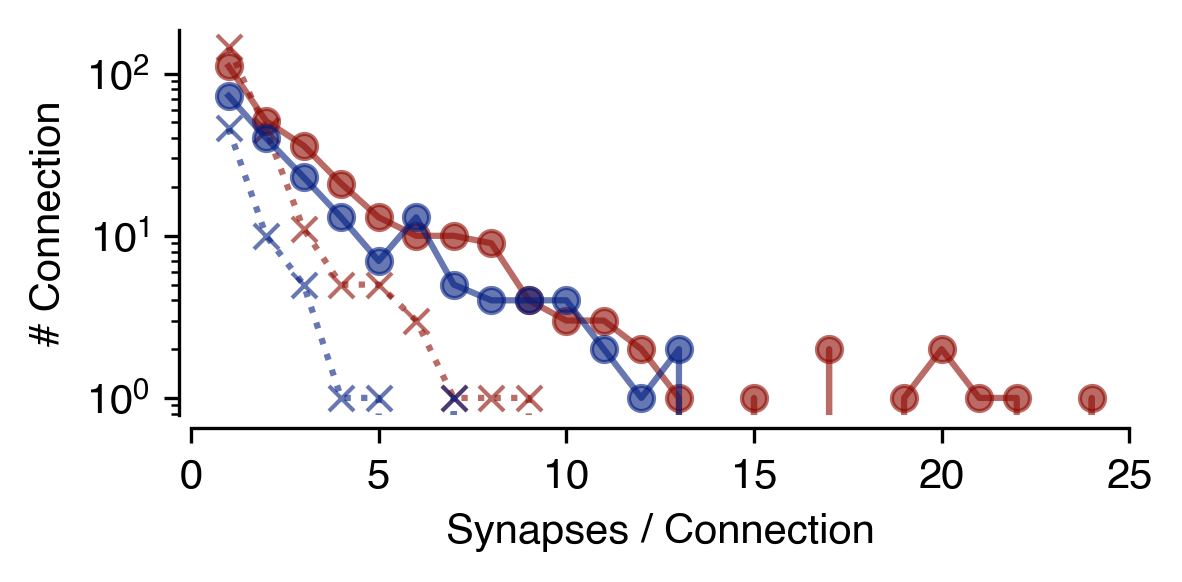

In [89]:
fig, ax = plt.subplots(figsize=(4,2), dpi=300)

ax.plot(
    y[0:-1], x_dtc_dtc, marker='o', color=ctype_hues['DTC'], linestyle='-', alpha=0.6,
)
ax.plot(
    y[0:-1], x_dtc_other, marker='x', color=ctype_hues['DTC'], linestyle=':', alpha=0.6,
)

ax.plot(
    y[0:-1], x_ptc_ptc, marker='o', color=ctype_hues['PTC'], linestyle='-', alpha=0.6,
)
ax.plot(
    y[0:-1], x_ptc_other, marker='x', color=ctype_hues['PTC'], linestyle=':', alpha=0.6,
)

ax.set_yscale('log')
ax.set_xlim(0,25)
ax.set_xlabel('Synapses / Connection')
ax.set_ylabel('# Connection')
fig.tight_layout()
sns.despine(ax=ax, offset=3)
# fig.savefig(f"{plot_dir}/inhtc_connection_weight.pdf", bbox_inches='tight')

In [307]:
x_dtc_dtc

array([111,  51,  36,  21,  13,  10,  10,   9,   4,   3,   3,   2,   1,
         0,   1,   0,   2,   0,   1,   2,   1,   1,   0,   1,   0,   0,
         0,   0,   0,   0,   0,   0,   1])

<Axes: xlabel='id', ylabel='Count'>

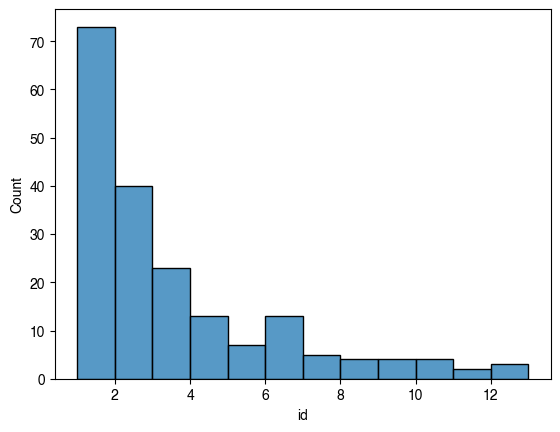

In [298]:
sns.histplot(inh_ptc_syns_all.query('cell_type_post=="PTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'])

In [356]:
1.8/100_000

1.8e-05

In [350]:
5 / (80_000 + 200_000)

1.785714285714286e-05

<Axes: xlabel='id', ylabel='Count'>

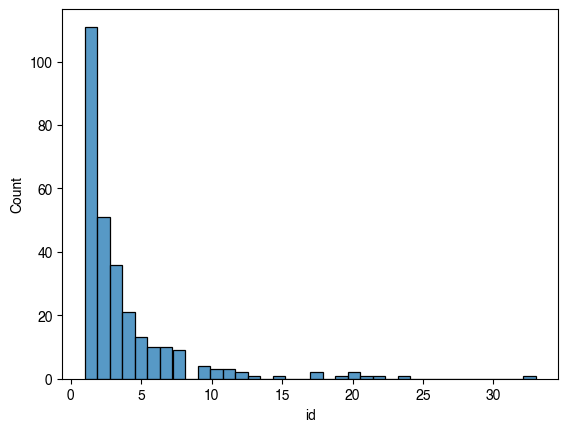

In [299]:
sns.histplot(inh_dtc_syns_all.query('cell_type_post=="DTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'])

<Axes: xlabel='id', ylabel='Count'>

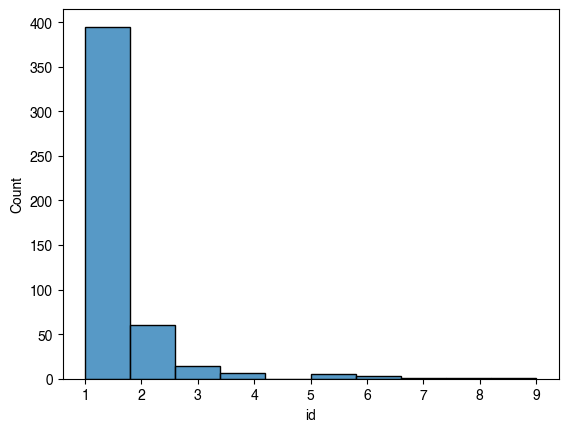

In [300]:
sns.histplot(inh_dtc_syns_all.query('cell_type_post!="DTC"').groupby(['pre_pt_root_id','post_pt_root_id']).count()['id'])

In [257]:
inh_ptc_syns_all.query('cell_type_post=="PTC"')['dist_to_root'].median(), inh_dtc_syns_all.query('cell_type_post=="DTC"')['dist_to_root'].median()

(86.23168002319335, 83.52166438293457)

<Axes: xlabel='cell_type_post', ylabel='dist_to_root'>

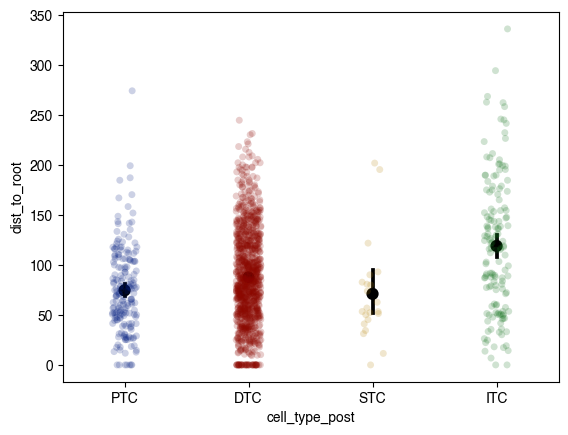

In [217]:
sns.stripplot(
    y='dist_to_root',
    x='cell_type_post',
    hue='cell_type_post',
    palette=ctype_hues,
    data=inh_dtc_syns_all,
    alpha=0.2,
    legend=False,
)

sns.pointplot(
    y='dist_to_root',
    x='cell_type_post',
    color='k',
    data=inh_dtc_syns_all,
    join=False,
)

<Axes: xlabel='cell_type_post', ylabel='dist_to_root'>

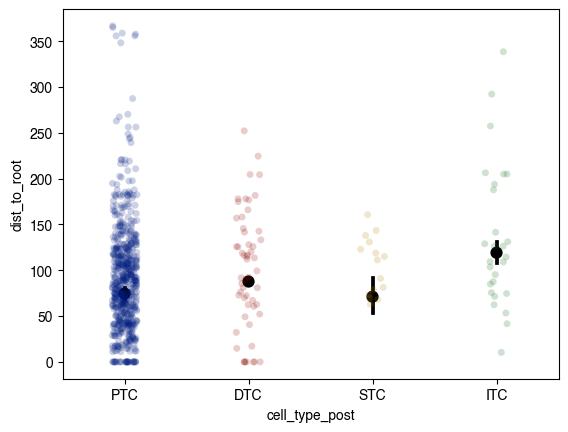

In [218]:
sns.stripplot(
    y='dist_to_root',
    x='cell_type_post',
    hue='cell_type_post',
    palette=ctype_hues,
    data=inh_ptc_syns_all,
    alpha=0.2,
    legend=False,
)

sns.pointplot(
    y='dist_to_root',
    x='cell_type_post',
    color='k',
    data=inh_dtc_syns_all,
    join=False,
)

In [177]:
res = sm.stats.multicomp.pairwise_tukeyhsd(
    inh_dtc_syns_all.query('cell_type_post == cell_type_post')['size'].astype(float),
    np.array(inh_dtc_syns_all.query('cell_type_post == cell_type_post')['cell_type_post'].values),
)

res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
DTC,ITC,-1534.2695,0.0004,-2525.8653,-542.6738,True
DTC,PTC,-1725.5447,0.0,-2619.7053,-831.3842,True
DTC,STC,-3021.3629,0.0074,-5442.8983,-599.8276,True
ITC,PTC,-191.2752,0.9788,-1429.9123,1047.3619,False
ITC,STC,-1487.0934,0.4444,-4055.8542,1081.6675,False
PTC,STC,-1295.8182,0.5528,-3828.5624,1236.926,False


In [178]:
res = sm.stats.multicomp.pairwise_tukeyhsd(
    inh_ptc_syns_all.query('cell_type_post == cell_type_post')['size'].astype(float),
    np.array(inh_ptc_syns_all.query('cell_type_post == cell_type_post')['cell_type_post'].values),
)

res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
DTC,ITC,-676.6088,0.858,-2876.0616,1522.8441,False
DTC,PTC,1797.2863,0.0027,477.6828,3116.8898,True
DTC,STC,-635.9273,0.9318,-3362.3488,2090.4942,False
ITC,PTC,2473.895,0.0032,631.8271,4315.963,True
ITC,STC,40.6815,1.0,-2973.4909,3054.8539,False
PTC,STC,-2433.2136,0.052,-4880.4561,14.0289,False


In [389]:
ct_list_inh

['PTC', 'DTC', 'ITC', 'STC']

In [390]:
syn_table_select['ptc_frac_inh'] = (syn_table_select[ct_list_inh].values / syn_table_select[ct_list_inh].sum(axis=1).values.reshape(-1,1))[:,0]
syn_table_select['dtc_frac_inh'] = (syn_table_select[ct_list_inh].values / syn_table_select[ct_list_inh].sum(axis=1).values.reshape(-1,1))[:,1]

In [410]:
syn_table_select['l4_fraction'] = syn_table_select[['L4a_norm', 'L4b_norm', 'L4c_norm']].sum(axis=1)

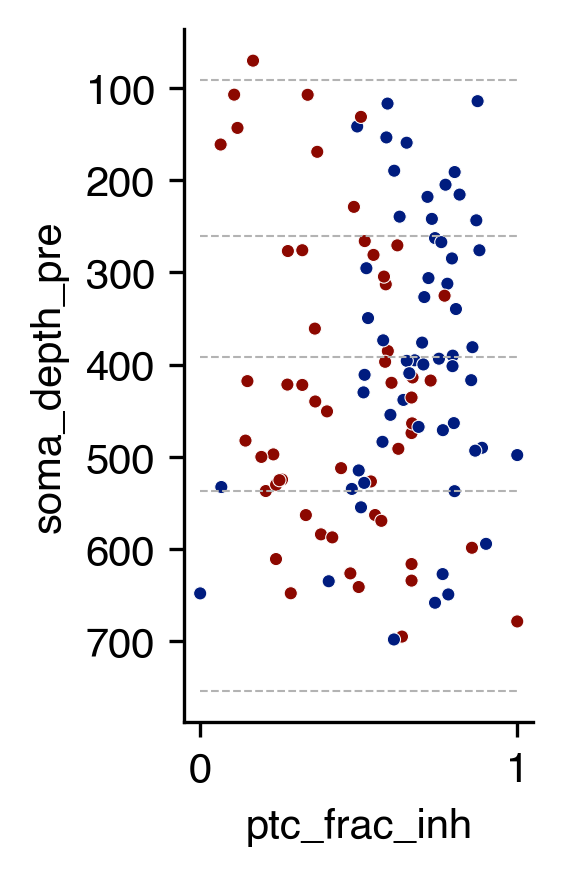

In [406]:
fig, ax = plt.subplots(figsize=(1.5,3), dpi=300)
sns.scatterplot(
    y='soma_depth_pre',
    x='ptc_frac_inh',
    data=syn_table_select.query('cell_type_pre in ["DTC", "PTC"]'),
    hue='cell_type_pre',
    palette=ctype_hues,
    ax=ax,
    s=10,
    legend=None,
)
ax.hlines(layer_bounds, 0,1, linestyle='--', color=(0.7, 0.7, 0.7), linewidth=0.5)
ax.invert_yaxis()
sns.despine(ax=ax)

In [420]:
syn_table_select['num_exc_syn'] = syn_table_select[ct_list_exc].sum(axis=1)

In [426]:
syn_table_select['num_inh_syn'] = syn_table_select[ct_list_inh].sum(axis=1)

In [433]:
syn_table_select['frac_exc'] = syn_table_select['num_exc_syn'] / syn_table_select.net_syn

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


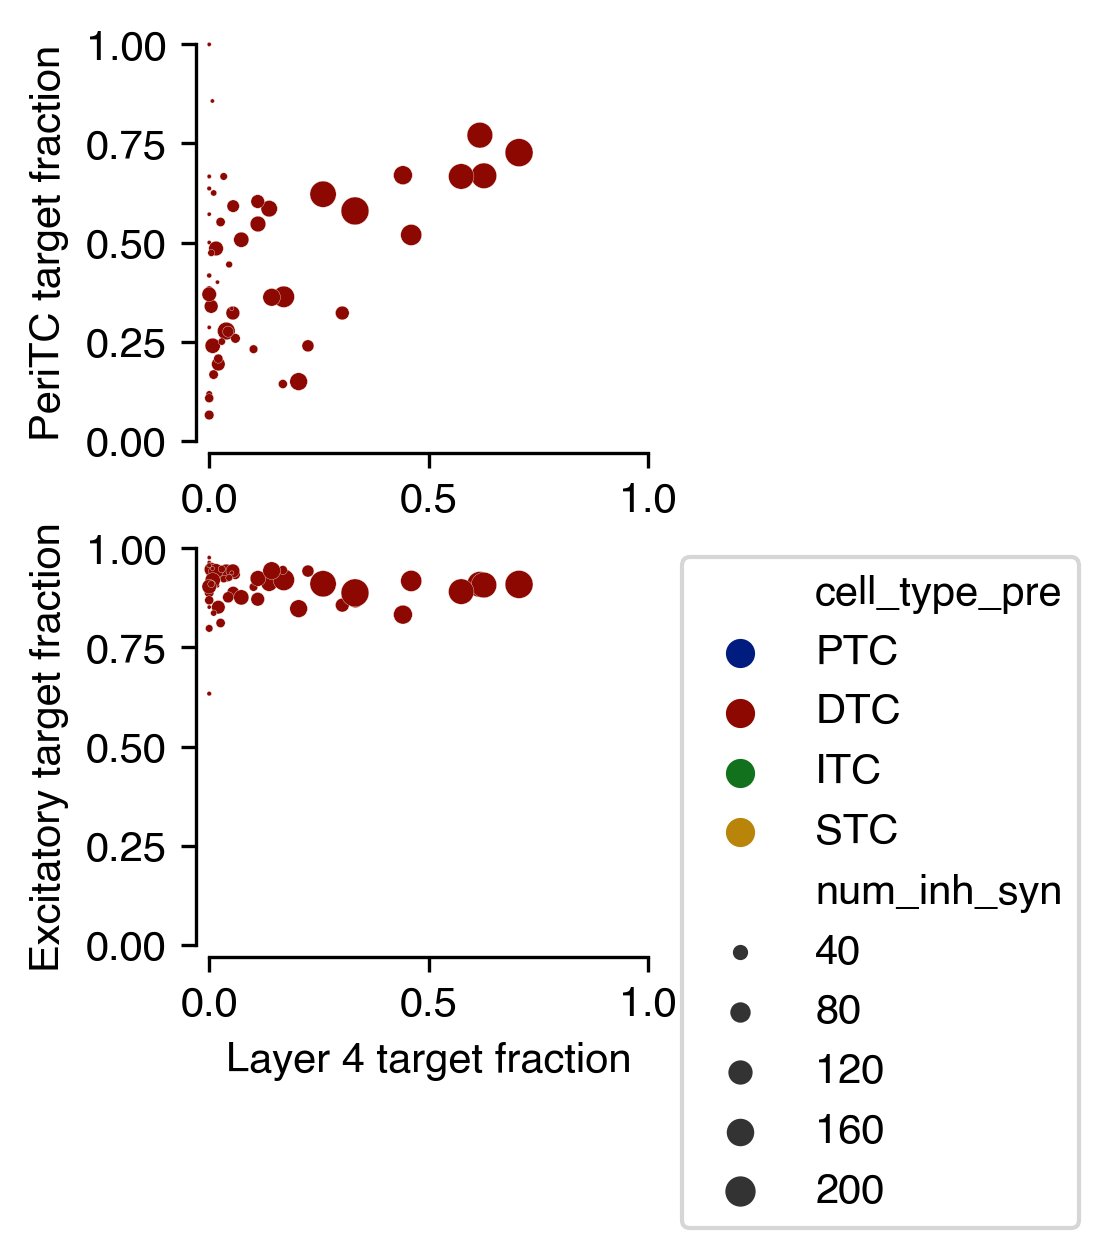

In [457]:
fig, axes = plt.subplots(figsize=(2,4), nrows=2, dpi=300)
ax = axes[0]
sns.scatterplot(
    x='l4_fraction',
    y='ptc_frac_inh',
    size='num_inh_syn',
    size_norm=(10, 500),
    sizes=(1,100),
    data=syn_table_select.query('cell_type_pre in ["DTC"]'),
    hue='cell_type_pre',
    palette=ctype_hues,
    ax=ax,
    legend=None,
)
ax.set_xlim((-0.03,1.03))
ax.set_ylim((-0.03,1.03))

ax.set_xlabel('Layer 4 target fraction')
ax.set_ylabel('PeriTC target fraction')
sns.despine(ax=ax, trim=True)


ax = axes[1]
sns.scatterplot(
    x='l4_fraction',
    y='frac_exc',
    size='num_inh_syn',
    size_norm=(10, 500),
    sizes=(1,100),
    data=syn_table_select.query('cell_type_pre in ["DTC"]'),
    hue='cell_type_pre',
    palette=ctype_hues,
    ax=ax,
    legend=True,
)

ax.set_xlim((-0.03,1.03))
ax.set_ylim((-0.03,1.03))
ax.legend().set_bbox_to_anchor((1,1))
ax.set_xlabel('Layer 4 target fraction')
ax.set_ylabel('Excitatory target fraction')
sns.despine(ax=ax, trim=True)
fig.savefig(f"{plot_dir}/dist_tc_vs_layer4_targeting.pdf", bbox_inches='tight')

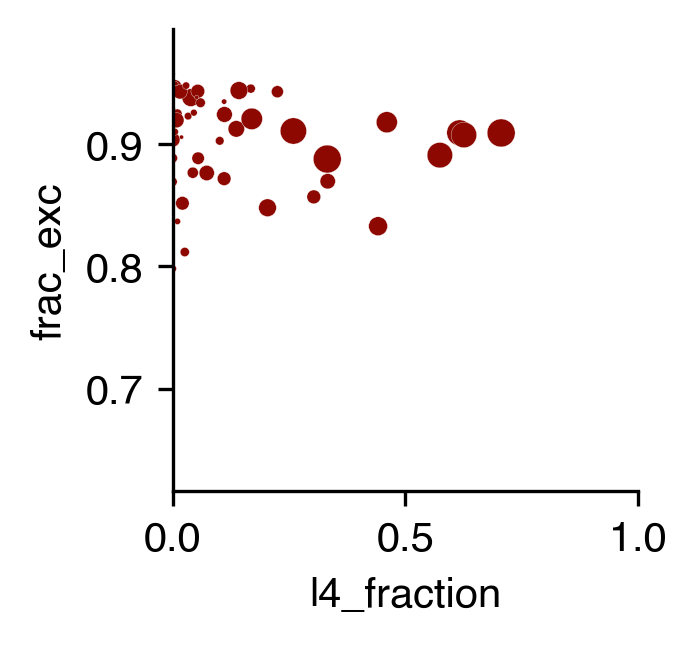

In [437]:
fig, ax = plt.subplots(figsize=(2,2), dpi=300)
sns.scatterplot(
    x='l4_fraction',
    y='frac_exc',
    size='num_inh_syn',
    size_norm=(10, 500),
    sizes=(1,100),
    data=syn_table_select.query('cell_type_pre in ["DTC"]'),
    hue='cell_type_pre',
    palette=ctype_hues,
    ax=ax,
    legend=None,
)
ax.set_xlim((0,1))
sns.despine(ax=ax)